# Трейдинг с использованием нейронных сетей!

In [1]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install tqdm
!pip install sklearn

In [2]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv1D, Conv2D, Reshape, Flatten, Multiply,\
Dense,  Dropout, Input, Lambda, LSTM, Concatenate, MaxPooling1D, SpatialDropout1D, BatchNormalization
from tensorflow.keras import backend
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.callbacks import LambdaCallback, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from IPython.display import clear_output
import matplotlib.pyplot as plt 
from collections import deque
import random
from tensorflow.keras.utils import to_categorical, plot_model
from tqdm.notebook import tqdm as tqdm
import time
from collections import deque
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
import os
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from IPython.display import clear_output
import sys

In [3]:
import pkg_resources
import types
def get_imports(): # выводим версии используемых библиотек
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            name = val.__name__.split('.')[0]
        elif isinstance(val, type):
            name = val.__module__.split('.')[0]
        poorly_named_packages = {'PIL': 'Pillow', 'sklearn': 'scikit-learn'}
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]
        yield name


imports = list(set(get_imports()))
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name != 'pip':
        requirements.append((m.project_name, m.version))

for r in requirements:
    print('{}=={}'.format(*r))

tqdm==4.60.0
tensorflow==2.4.1
scikit-learn==0.24.2
pandas==1.1.5
numpy==1.19.5
matplotlib==3.3.4


In [5]:
pip install pandas_datareader

Note: you may need to restart the kernel to use updated packages.


In [5]:
from pandas_datareader import data as pdr#pandas_datareader.data and pandas_datareader.wb извлекает данные из различных интернет ресурсов и представляет их в форме таблиц пандас (DataFrame). 

In [38]:
# ресурсы, которые поддерживаются этой функцией можно посмотреть по ссылке https://pandas-datareader.readthedocs.io/en/latest/remote_data.html 
import yfinance as yf #импортируем библиотеку
yf.pdr_override()#устанавливает pandas_datareader как приоритетный способ загрузки данных 
df_full = pdr.get_data_yahoo("JPM", start="2010-01-01").reset_index()# по тикеру JPM загружем данные джи пи морган, начиная с января 2018 года, обновляем индексы
df_full.to_csv(r'C:\Users\takhi\Desktop\Diploma\JPM.csv',index=True)# сохраняем у себя на диске по указанному пути в виде csv файла
df_full.head()

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-12-31,41.619999,42.130001,41.450001,41.669998,31.166878,20143100
1,2010-01-04,41.790001,42.990002,41.669998,42.849998,32.087944,35460500
2,2010-01-05,42.790001,43.840000,42.779999,43.680000,32.709484,41208300
3,2010-01-06,43.450001,44.090000,43.310001,43.919998,32.889217,27729000
4,2010-01-07,43.790001,45.119999,43.610001,44.790001,33.540695,44864700


In [1]:
df = pd.read_csv(r'C:\Users\takhi\Desktop\Diploma\JPM.csv')# создаем таблицу пандас из загруженного файл
df.head()

NameError: name 'pd' is not defined

In [11]:
df.shape

(2876, 8)

In [161]:
pip install ipywidgets

Note: you may need to restart the kernel to use updated packages.


# Conv1D

In [93]:
state_size = 30
action_size = 2
model = Sequential() 
model.add(Conv1D(64, 5, activation ='relu', padding = 'same', input_shape=(state_size,1))) 
model.add(Conv1D(32,5,padding='same', activation='relu'))
model.add(Flatten())
#self.model.add(Dense(32, activation = 'relu'))
model.add(Dense(action_size, activation = 'linear'))
model.compile(loss = 'mse', optimizer = Adam(learning_rate=0.0001))
model.load_weights(r'C:\Users\takhi\Desktop\Diploma\Conv1D_weights\conv1D_model_29.h5')

In [124]:
name = 'Q-learning agent_conv1D'

class Agent:
    def __init__(self, state_size, window_size, trend, skip, batch_size):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 2
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000)
        self.inventory = []

        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999

  
        self.model = Sequential() 
        self.model.add(Conv1D(64, 5, activation ='relu', padding = 'same', input_shape=(self.state_size,1))) 
        self.model.add(Conv1D(32,5,padding='same', activation='relu'))
        self.model.add(Flatten())
        #self.model.add(Dense(32, activation = 'relu'))
        self.model.add(Dense(self.action_size, activation = 'linear'))
        self.model.compile(loss = 'mse', optimizer = Adam(learning_rate=0.0001))
        
            
    with open(r'C:\Users\takhi\Desktop\Diploma\conv1D_log.txt', 'w+') as f:
        f.write('Train LSTM')
        f.write('\n')
        

    def act(self, state):
      if random.random() <= self.epsilon:
        return random.randrange(self.action_size)
      return np.argmax(self.model.predict(state))

    def get_state(self, t): # получить срез данных за window_size периодов - 30. Это набор данных с  разницей цены акции между двумя последующими периодами (i+1),  i
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i]) # записываем разницу в стоимости акции между следующим днем и текущим 
        return np.array([res]).reshape(-1,30,1)

    def replay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        #for i in range(batch_size):
        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])
        #replay_size = len(mini_batch)
        X = np.empty((batch_size, self.state_size,1))
        Y = np.empty((batch_size, self.action_size))
        #X = np.empty((replay_size, self.state_size))
        #Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
      
        Q = self.model.predict(states)

        Q_new = self.model.predict(new_states)

        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i] # возможные  действия для каждого шага
            target[action] = reward # награда на выбранном действии
            if not done:
                target[action] += self.gamma * np.amax(Q_new[i])
            X[i] = state
            Y[i] = target
        cost = self.model.train_on_batch(X,Y)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return cost
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            
            if action == 0 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
                
                
            elif action == 1 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
        
    def train(self, iterations, checkpoint, initial_money):
        loss =[]
        final_profit = []
        total_money = []
        final_inventory = []
        for i in tqdm(range(iterations)):
            total_profit = 0
            inventory = []
            state = self.get_state(0) # получаем первое состояние
            starting_money = initial_money # копируем начальный бюджет в starting_money
            p = range(0, len(self.trend)-1, self.skip)
            for t in tqdm(p):
                action = self.act(state)
                next_state = self.get_state(t + 1)
                
                if action == 0 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 1 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest, 
                                    next_state, starting_money < initial_money))
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)
                loss.append(cost)
            #self.model.save_weights('/content/drive/MyDrive/Trading/Conv1D_model_weights/Conv1D_model_'+str(i)+ '.h5')
                
            if (i+1) % checkpoint == 0:

                self.model.save_weights(r'C:\Users\takhi\Desktop\Diploma\Conv1D_weights\conv1D_model_'+str(i) + '.h5')
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f' %(i + 1, total_profit, cost,
                                                                                              starting_money))  
                with open(r'C:\Users\takhi\Desktop\Diploma\conv1D_log.txt', 'a+') as f:

                    f.write('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'% (i + 1, total_profit, cost,
                                                                                      starting_money))
                    f.write('\n')
            final_profit.append(total_profit)
            total_money.append(starting_money) 
            final_inventory.append(inventory)                                                        
        print('total rewards: %f.3, cost: %f, total money: %f' % (total_profit, cost,
                                                                      starting_money))                                                                         
        return loss, final_profit, total_money, final_inventory

In [125]:
close = df.Close.values.tolist()[2013:2516]# обучим модель  Conv1D на данных за два предыдущих года 2018-2019
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)
loss, final_profit, total_money, inventory = agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

epoch: 10, total rewards: 0.600006.3, cost: 0.000002, total money: 10000.600006


  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

epoch: 20, total rewards: -1.699997.3, cost: 0.000000, total money: 9998.300003


  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

epoch: 30, total rewards: 2.150009.3, cost: 0.000000, total money: 10002.150009


  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

epoch: 40, total rewards: 0.619995.3, cost: 0.000000, total money: 10000.619995


  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

epoch: 50, total rewards: -0.860001.3, cost: 0.000000, total money: 9999.139999


  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

epoch: 60, total rewards: 1.100006.3, cost: 0.000000, total money: 10001.100006


  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

epoch: 70, total rewards: 0.049995.3, cost: 0.000000, total money: 10000.049995


  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

epoch: 80, total rewards: 1.830002.3, cost: 0.000000, total money: 10001.830002


  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

epoch: 90, total rewards: -0.169998.3, cost: 0.000000, total money: 9999.830002


  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/502 [00:00<?, ?it/s]

epoch: 100, total rewards: 0.500000.3, cost: 0.000000, total money: 10000.500000
total rewards: 0.500000.3, cost: 0.000000, total money: 10000.500000


In [130]:
close = df.Close.values.tolist()[2577:2770]# обучим модель  Conv1D на данных за 
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 0: buy 1 unit at price 93.500000, total balance 9906.500000
day 1: buy 1 unit at price 90.029999, total balance 9816.470001
day 2, sell 1 unit at price 84.360001, investment -9.775400 %, total balance 9900.830002,
day 3: buy 1 unit at price 87.510002, total balance 9813.320000
day 4: buy 1 unit at price 84.050003, total balance 9729.269997
day 5: buy 1 unit at price 89.459999, total balance 9639.809998
day 6, sell 1 unit at price 90.639999, investment 0.677553 %, total balance 9730.449997,
day 7: buy 1 unit at price 94.300003, total balance 9636.149994
day 8: buy 1 unit at price 102.760002, total balance 9533.389992
day 9, sell 1 unit at price 98.190002, investment 12.204320 %, total balance 9631.579994,
day 10, sell 1 unit at price 95.500000, investment 13.622839 %, total balance 9727.079994,
day 11: buy 1 unit at price 90.790001, total balance 9636.289993
day 12: buy 1 unit at price 87.330002, total balance 9548.959991
day 13: buy 1 unit at price 95.180000, total balance 9453.779

In [109]:
df[df.Date == '2020-01-02']

,Unnamed: 0,Date,Open,High,Low,Close,Adj Close,Volume
2517,2517,2020-01-02,139.789993,141.100006,139.259995,141.089996,134.380966,10803700


In [126]:
def Conv1D_buy_stock(initial_money, trend, window_size):
    starting_money = initial_money
    states_sell = []
    states_buy = []
    inventory = []
    skip = 1
    action_list = []
    
    state_size = 30
    action_size = 2
    model = Sequential() 
    model.add(Conv1D(64, 5, activation ='relu', padding = 'same', input_shape=(state_size,1))) 
    model.add(Conv1D(32,5,padding='same', activation='relu'))
    model.add(Flatten())
    #self.model.add(Dense(32, activation = 'relu'))
    model.add(Dense(action_size, activation = 'linear'))
    model.compile(loss = 'mse', optimizer = Adam(learning_rate=0.0001))
    model.load_weights(r'C:\Users\takhi\Desktop\Diploma\Conv1D_weights\conv1D_model_49.h5')
    
    def get_state(t , window_size = window_size): # получить срез данных за window_size периодов - 30. Это набор данных с  разницей цены акции между двумя последующими периодами (i+1),  i
        if t < 30:
            pass
        else:
            window_size = window_size + 1
            d = t - window_size + 1
            block = trend[d : t + 1] if d >= 0 else -d * [trend[0]] + trend[0 : t + 1]
            res = []
            for i in range(window_size - 1):
                res.append(block[i + 1] - block[i]) # записываем разницу в стоимости акции между следующим днем и текущим 
        return np.array([res]).reshape(-1,30,1)
    


    state = get_state(30)
    for t in range(31, len(trend) - 1, skip):
        pred = model.predict(state)
        action = np.argmax(pred)
        next_state = get_state(t+1)
        action_list.append(action)

        if action == 0 and initial_money >= trend[t]:
            inventory.append(trend[t])
            initial_money -= trend[t]
            states_buy.append(t)
            print('day %d: buy 1 unit at price %f, total balance %f, inventory %f'% (t, trend[t], initial_money, sum(inventory)))

        elif action == 1 and len(inventory):
            bought_price = inventory.pop(0)
            initial_money += trend[t]
            states_sell.append(t)
            try:
                invest = ((close[t] - bought_price) / bought_price) * 100
            except:
                invest = 0
            print(
                'day %d, sell 1 unit at price %f, investment %f %%, total balance %f, inventory %f'
                % (t, close[t], invest, initial_money, sum(inventory)))
            

        state = next_state  
    invest = ((initial_money - starting_money) / starting_money) * 100
    total_gains = initial_money - starting_money
    return states_buy, states_sell, total_gains, invest, sum(inventory), action_list

In [127]:
close = df.Close.values.tolist()[2487:2770]# проверим эффективность модели с весами лучшей эпохи на тестовом периоде 2020 год  
initial_money = 10000
window_size = 30
skip = 1
states_buy, states_sell, total_gains, invest, inventory, action_list = Conv1D_buy_stock(initial_money = 10000, trend = close,window_size = 30)


day 100: buy 1 unit at price 95.500000, total balance 9904.500000, inventory 95.500000
day 101, sell 1 unit at price 90.790001, investment -4.931936 %, total balance 9995.290001, inventory 0.000000


In [128]:
action_list

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


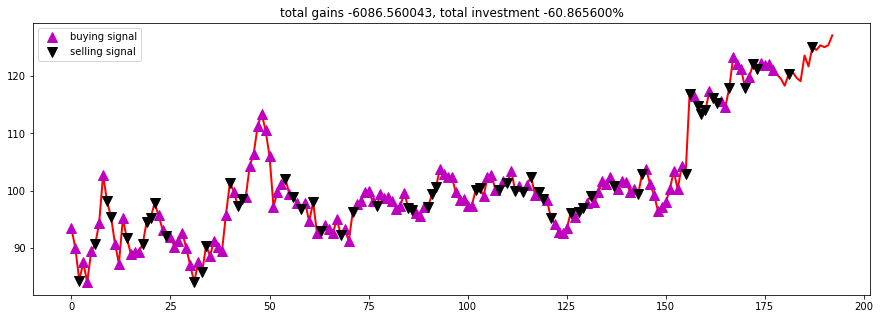

In [132]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.savefig(r'C:\Users\takhi\Desktop\Diploma\Conv1D_100_.png')
plt.show()

# LSTM

LEARNING_RATE = 0.0001
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape = (4,30), name='lstm1'))
model.add(LSTM(64 //4, name='lstm2'))
model.add(Dense(2, name='dense'))
model.compile(loss = 'mse', optimizer = Adam(lr = LEARNING_RATE))
#model.save_weights('Tri.h5')
model.load_weights(r'C:\Users\takhi\Desktop\Diploma\LSTM_weights2\lstm_model_199.h5')

In [51]:
#EPSILON = 0.5
DECAY_RATE = 0.005
MIN_EPSILON = 0.1
for i in range(100):
    EPSILON = MIN_EPSILON + (1.0 -MIN_EPSILON) * np.exp(-DECAY_RATE * i)
EPSILON

0.6486138165666783

In [38]:
name = 'Recurrent Q-learning agent'
        
class Agent:

    LEARNING_RATE = 0.0001
    BATCH_SIZE = 32
    LAYER_SIZE = 64
    OUTPUT_SIZE = 2
    EPSILON = 0.45
    DECAY_RATE = 0.0005
    MIN_EPSILON = 0.1
    GAMMA = 0.99
    MEMORIES = deque()
    MEMORY_SIZE = 300
    model = model

    
    with open(r'C:\Users\takhi\Desktop\Diploma\lstm_log2.txt', 'w+') as f:
        f.write('Train LSTM')
        f.write('\n')
        
 
    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
 
        self.INITIAL_FEATURES = np.zeros((4, self.state_size))
    


    def _memorize(self, state, action, reward, new_state, dead):
        self.MEMORIES.append((state, action, reward, new_state, dead))
        if len(self.MEMORIES) > self.MEMORY_SIZE:
            self.MEMORIES.popleft()

    def _construct_memories(self, replay): # replay  имеет длину batch_size 
        states = np.array([a[0] for a in replay]) # размерность должна быть трехмерная (32,4,30)
        new_states = np.array([a[3] for a in replay]) # размерность должна быть трехмерная (32,4,30)
        #init_values = np.array([a[-1] for a in replay])
        Q = self.model.predict(states)
        Q_new = self.model.predict(new_states)

        replay_size = len(replay)
        X = np.empty((replay_size, 4, self.state_size))
        Y = np.empty((replay_size, self.OUTPUT_SIZE))
        for i in range(replay_size):
            state_r, action_r, reward_r, new_state_r, dead_r = replay[i]
            target = Q[i]# здесь будет массив из трех значений, предсказанных сетью 
            target[action_r] = reward_r # для конкретного совершенного действия меняем значение в массиве на значение полученной награды
            if not dead_r:
                target[action_r] += self.GAMMA * np.amax(Q_new[i]) # увеличиваем это значение максимальное значение, предсказанное сетью на следующем шаге
            X[i] = state_r
            Y[i] = target
        return X, Y 
    
    def get_state(self, t): # состояния  - это разница  в цене акции между двумя последующими днями за определенный период
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array(res)
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for k in range(self.INITIAL_FEATURES.shape[0]):
            self.INITIAL_FEATURES[k,:] = state
        for t in range(0, len(self.trend) - 1, self.skip):
            pred = self.model.predict(self.INITIAL_FEATURES.reshape(1,4,30))
            action = np.argmax(pred)

            
            if action == 0 and initial_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            
            elif action == 1 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            new_state = np.append([self.get_state(t + 1)], self.INITIAL_FEATURES[:3, :], axis = 0)
            self.INITIAL_FEATURES = new_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
            
    
    def train(self, iterations, checkpoint, initial_money):
        loss =[]
        final_profit = []
        total_money = []
        final_inventory = []
        
        for i in tqdm(range(iterations)):
            start_time = time.time()
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            #init_value = np.zeros((1, 2 * self.LAYER_SIZE))
            for k in range(self.INITIAL_FEATURES.shape[0]):
                self.INITIAL_FEATURES[k,:] = state
            for t in range(0, len(self.trend) - 1, self.skip):
                
                if np.random.rand() < self.EPSILON:
                    action = np.random.randint(self.OUTPUT_SIZE)
                else:

                    pred = self.model.predict(self.INITIAL_FEATURES.reshape(-1,4,30))
                    action = np.argmax(pred)                                         
                    
                next_state = self.get_state(t + 1)
                
                if action == 0 and starting_money >= self.trend[t]:
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 1 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                new_state = np.append([self.get_state(t + 1)], self.INITIAL_FEATURES[:3, :], axis = 0)
                self._memorize(self.INITIAL_FEATURES, action, invest, new_state, 
                               starting_money < initial_money) #init_value[0])
                self.INITIAL_FEATURES = new_state
                batch_size = min(len(self.MEMORIES), self.BATCH_SIZE)
                replay = random.sample(self.MEMORIES, batch_size)
                X, Y = self._construct_memories(replay)
                
                cost = self.model.train_on_batch(X,Y)
                loss.append(cost)

       
                if self.EPSILON > self.MIN_EPSILON:
                    self.EPSILON -=self.DECAY_RATE
                else:
                    self.EPSILON = self.MIN_EPSILON
                    
                #self.EPSILON = self.MIN_EPSILON + (1.0 - self.MIN_EPSILON) * np.exp(-self.DECAY_RATE * i)
                
            if (i+1) % checkpoint == 0:
                self.model.save_weights(r'C:\Users\takhi\Desktop\Diploma\LSTM_weights2\lstm_model_'+str(i)+'.h5')
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f, time: %f.1'%(i + 1, total_profit, cost,
                                                                                  starting_money, round(time.time()-start_time,2)))
                
                with open(r'C:\Users\takhi\Desktop\Diploma\lstm_log2.txt', 'a+') as f:

                    f.write('epoch: %d, total rewards: %f.3, cost: %f, total money: %f, time: %f.1'% (i + 1, total_profit, cost,
                                                                                      starting_money, round(time.time()-start_time,2)))
                    f.write('\n')
                start_time = time.time()
                
            #final_profit.append(total_profit)
            #total_money.append(starting_money) 
            #final_inventory.append(inventory) 
            #return  loss, final_profit, total_money, final_inventory

In [39]:
close = df.Close.values.tolist()[2013:2516]# обучим модель  LSTM на данных за два предыдущих года 2018-2019 ещё 20 эпох
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
             )
agent.train(iterations = 20, checkpoint = 5, initial_money = initial_money)

  0%|          | 0/20 [00:00<?, ?it/s]

epoch: 5, total rewards: 0.189995.3, cost: 0.000000, total money: 10000.189995, time: 39.740000.1
epoch: 10, total rewards: -1.789978.3, cost: 0.000000, total money: 9998.210022, time: 41.140000.1
epoch: 15, total rewards: -2.870003.3, cost: 0.000001, total money: 9997.129997, time: 40.050000.1
epoch: 20, total rewards: 2.329979.3, cost: 0.000005, total money: 10002.329979, time: 39.580000.1


In [59]:
df.Close[df.Date=='2020-12-31']

2769    127.07
Name: Close, dtype: float64

In [20]:
df.iloc[2517]

Unnamed: 0          2517
Date          2020-01-02
Open              139.79
High               141.1
Low               139.26
Close             141.09
Adj Close        134.381
Volume          10803700
Name: 2517, dtype: object

[2517:2770] это 2020 год

In [41]:
close = df.Close.values.tolist()[2577:2770]# проверим эффективность модели с весами лучшей эпохи на тестовом периоде 2020 год  LSTM на данных за два предыдущих года 2018-2019
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
             )

In [81]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 10: buy 1 unit at price 95.500000, total balance 9904.500000
day 11, sell 1 unit at price 90.790001, investment -4.931936 %, total balance 9995.290001,
day 13: buy 1 unit at price 95.180000, total balance 9900.110001
day 14: buy 1 unit at price 91.709999, total balance 9808.400002
day 15, sell 1 unit at price 89.050003, investment -6.440426 %, total balance 9897.450005,
day 16, sell 1 unit at price 89.339996, investment -2.584236 %, total balance 9986.790001,
day 18: buy 1 unit at price 90.709999, total balance 9896.080002
day 19, sell 1 unit at price 94.620003, investment 4.310444 %, total balance 9990.700005,
day 23: buy 1 unit at price 93.250000, total balance 9897.450005
day 24: buy 1 unit at price 92.139999, total balance 9805.310005
day 25, sell 1 unit at price 92.000000, investment -1.340483 %, total balance 9897.310005,
day 26: buy 1 unit at price 90.269997, total balance 9807.040009
day 27: buy 1 unit at price 91.209999, total balance 9715.830009
day 28, sell 1 unit at pri

In [76]:
def LSTM_buy_stock(initial_money, trend, window_size):
    starting_money = initial_money
    states_sell = []
    states_buy = []
    inventory = []
    skip = 1
    INITIAL_FEATURES = np.zeros((4, 30))
    
    def get_state(t, window_size = window_size): # состояния  - это разница  в цене акции между двумя последующими днями за определенный период
        res = []
        if t < 34:
            pass
        else:
            window_size = window_size + 1
            d = t - window_size + 1
            block = trend[d : t + 1] if d >= 0 else -d * [trend[0]] + trend[0 : t + 1]
            for i in range(window_size - 1):
                res.append(block[i + 1] - block[i])
        return np.array(res)
    
    state = []
    for j in range(30,34):
        st = get_state(j)
        state.append(j)
        
    for k in range(INITIAL_FEATURES.shape[0]):
        INITIAL_FEATURES[k,:] = state[k]

    for t in range(34, len(trend) - 1, skip):
        pred = model.predict(INITIAL_FEATURES.reshape(1,4,30))
        action = np.argmax(pred)


        if action == 0 and initial_money >= trend[t]:
            inventory.append(trend[t])
            initial_money -= trend[t]
            states_buy.append(t)
            print('day %d: buy 1 unit at price %f, total balance %f, inventory %f'% (t, trend[t], initial_money, sum(inventory)))

        elif (action == 1 and len(inventory)>0):
            bought_price = inventory.pop(0)
            initial_money += trend[t]
            states_sell.append(t)
            try:
                invest = ((close[t] - bought_price) / bought_price) * 100
            except:
                invest = 0
            print(
                'day %d, sell 1 unit at price %f, investment %f %%, total balance %f, inventory %f'
                % (t, close[t], invest, initial_money, sum(inventory)))
            

        new_state = np.append([get_state(t + 1)], INITIAL_FEATURES[:3, :], axis = 0)
        INITIAL_FEATURES = new_state
    invest = ((initial_money - starting_money) / starting_money) * 100
    total_gains = initial_money - starting_money
    return states_buy, states_sell, total_gains, invest, sum(inventory)

In [52]:
close = df.Close.values.tolist()[2483:2770]# проверим эффективность модели с весами лучшей эпохи на тестовом периоде 2020 год  LSTM на данных за два предыдущих года 2018-2019
initial_money = 10000
window_size = 30
skip = 1
states_buy, states_sell, total_gains, invest, inventory = buy_stock(initial_money = 10000, trend = close,window_size = 30)

day 80: buy 1 unit at price 100.699997, total balance 9899.300003, inventory 100.699997
day 81: buy 1 unit at price 95.959999, total balance 9803.340004, inventory 196.659996
day 82: buy 1 unit at price 88.050003, total balance 9715.290001, inventory 284.709999
day 83, sell 1 unit at price 103.910004, investment 3.187693 %, total balance 9819.200005, inventory 184.010002
day 84, sell 1 unit at price 88.360001, investment -7.919965 %, total balance 9907.560005, inventory 88.050003
day 85, sell 1 unit at price 93.760002, investment 6.484950 %, total balance 10001.320007, inventory 0.000000
day 86: buy 1 unit at price 83.889999, total balance 9917.430008, inventory 83.889999
day 87, sell 1 unit at price 85.300003, investment 1.680777 %, total balance 10002.730011, inventory 0.000000
day 90: buy 1 unit at price 88.430000, total balance 9914.300011, inventory 88.430000
day 91, sell 1 unit at price 91.730003, investment 3.731769 %, total balance 10006.030014, inventory 0.000000
day 95: buy 1

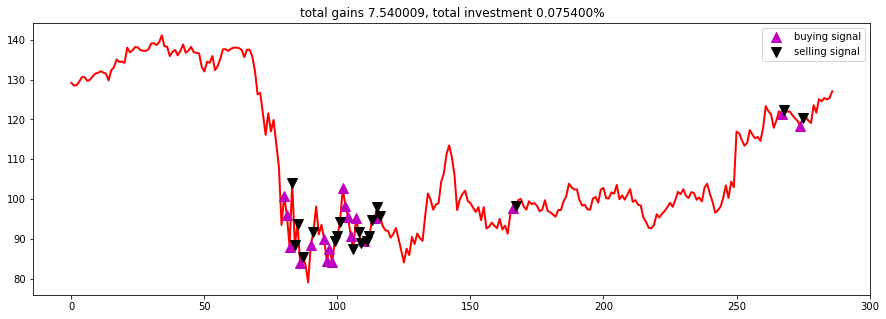

In [53]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.savefig(r'C:\Users\takhi\Desktop\Diploma\LSTM_220.png')
plt.show()

In [60]:
df.head(-1)

,Unnamed: 0,Date,Open,High,Low,Close,Adj Close,Volume
0,0,2009-12-31,41.619999,42.130001,41.450001,41.669998,31.166878,20143100
1,1,2010-01-04,41.790001,42.990002,41.669998,42.849998,32.087944,35460500
2,2,2010-01-05,42.790001,43.840000,42.779999,43.680000,32.709484,41208300
3,3,2010-01-06,43.450001,44.090000,43.310001,43.919998,32.889217,27729000
4,4,2010-01-07,43.790001,45.119999,43.610001,44.790001,33.540695,44864700
...,...,...,...,...,...,...,...,...
2851,2851,2021-04-30,154.100006,154.490005,153.009995,153.809998,153.809998,11703200
2852,2852,2021-05-03,154.850006,155.479996,153.130005,153.360001,153.360001,11801100
2853,2853,2021-05-04,152.869995,155.639999,152.139999,155.479996,155.479996,12977700
2854,2854,2021-05-05,156.000000,158.279999,156.000000,157.520004,157.520004,6938200


In [65]:
df[df.Date =='2021-01-04']

,Unnamed: 0,Date,Open,High,Low,Close,Adj Close,Volume
2770,2770,2021-01-04,127.5,127.860001,124.779999,125.870003,124.238274,16819900


In [68]:
close = df.Close.values.tolist()[2736:2855]# проверим эффективность модели с весами лучшей эпохи на тестовом периоде 2021 год  LSTM на данных за два предыдущих года 2018-2019
initial_money = 10000
window_size = 30
skip = 1
states_buy, states_sell, total_gains, invest, inventory = buy_stock(initial_money = 10000, trend = close,window_size = 30)

day 37: buy 1 unit at price 135.869995, total balance 9864.130005, inventory 135.869995
day 38, sell 1 unit at price 136.020004, investment 0.110406 %, total balance 10000.150009, inventory 0.000000
day 55: buy 1 unit at price 135.139999, total balance 9865.010010, inventory 135.139999
day 56: buy 1 unit at price 138.250000, total balance 9726.760010, inventory 273.389999
day 57: buy 1 unit at price 137.979996, total balance 9588.780014, inventory 411.369995
day 58: buy 1 unit at price 140.139999, total balance 9448.640015, inventory 551.509995
day 59: buy 1 unit at price 139.580002, total balance 9309.060013, inventory 691.089996
day 60, sell 1 unit at price 139.660004, investment 3.344683 %, total balance 9448.720016, inventory 555.949997
day 61, sell 1 unit at price 139.270004, investment 0.737797 %, total balance 9587.990021, inventory 417.699997
day 62, sell 1 unit at price 141.250000, investment 2.369912 %, total balance 9729.240021, inventory 279.720001
day 63, sell 1 unit at pr

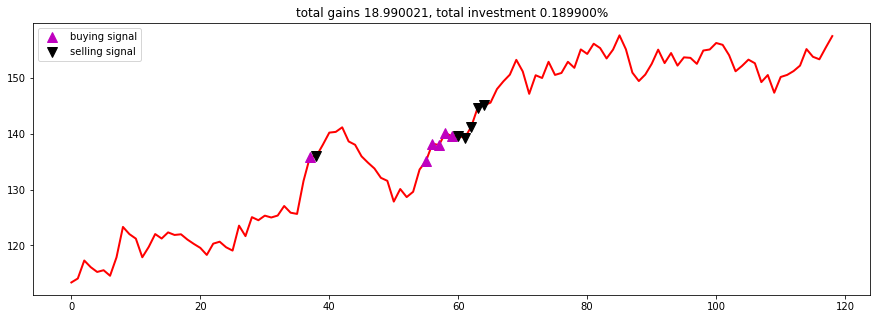

In [69]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.savefig(r'C:\Users\takhi\Desktop\Diploma\LSTM_200_2021.png')
plt.show()

# Временные ряды

In [19]:
df = pd.read_csv(r'C:\Users\takhi\Desktop\Diploma\JPM.csv')# создаем таблицу пандас из загруженного файл
df.head()

,Unnamed: 0,Date,Open,High,Low,Close,Adj Close,Volume
0,0,2009-12-31,41.619999,42.130001,41.450001,41.669998,31.166878,20143100
1,1,2010-01-04,41.790001,42.990002,41.669998,42.849998,32.087944,35460500
2,2,2010-01-05,42.790001,43.840000,42.779999,43.680000,32.709484,41208300
3,3,2010-01-06,43.450001,44.090000,43.310001,43.919998,32.889217,27729000
4,4,2010-01-07,43.790001,45.119999,43.610001,44.790001,33.540695,44864700


In [21]:
max(df.Volume.values), min(df.Volume.values)

(217294200, 3324300)

In [22]:
df_2 = df.copy()
df_2.drop(['Unnamed: 0', 'Adj Close'], axis = 1, inplace = True)
df_2.head(3)

,Date,Open,High,Low,Close,Volume
0,2009-12-31,41.619999,42.130001,41.450001,41.669998,20143100
1,2010-01-04,41.790001,42.990002,41.669998,42.849998,35460500
2,2010-01-05,42.790001,43.840000,42.779999,43.680000,41208300


In [13]:
df.drop(['Unnamed: 0', 'High', 'Low', 'Adj Close', 'Volume'], axis =1, inplace = True)
df.head(3)

,Date,Open,Close
0,2009-12-31,41.619999,41.669998
1,2010-01-04,41.790001,42.849998
2,2010-01-05,42.790001,43.680000


In [15]:
scaler = RobustScaler()
df['s_close'] = scaler.fit_transform(df.Close.values.reshape(-1,1))
df['s_open'] = scaler.transform(df.Open.values.reshape(-1,1))

In [16]:
for i in range(30):
    diff = df.Close.diff(i+1)
    df['tr_'+str(i+1)] = [1 if i >0 else 0 for i in diff]

In [17]:
df[:13]

,Date,Open,Close,s_open,s_close,tr_1,tr_2,tr_3,tr_4,tr_5,...,tr_21,tr_22,tr_23,tr_24,tr_25,tr_26,tr_27,tr_28,tr_29,tr_30
0,2009-12-31,41.619999,41.669998,-0.372868,-0.371965,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2010-01-04,41.790001,42.849998,-0.369799,-0.350663,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2010-01-05,42.790001,43.680000,-0.351747,-0.335680,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2010-01-06,43.450001,43.919998,-0.339832,-0.331348,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2010-01-07,43.790001,44.790001,-0.333694,-0.315642,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
5,2010-01-08,44.369999,44.680000,-0.323224,-0.317628,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
6,2010-01-11,45.119999,44.529999,-0.309685,-0.320336,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
7,2010-01-12,43.990002,43.490002,-0.330084,-0.339110,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,2010-01-13,43.549999,44.250000,-0.338027,-0.325390,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
9,2010-01-14,44.200001,44.689999,-0.326293,-0.317447,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [76]:
trend = 3
df.iloc[:3,3:5+trend]

,s_open,s_close,tr_1,tr_2,tr_3
0,-0.370926,-0.371072,0,0,0
1,-0.367856,-0.349671,1,0,0
2,-0.349797,-0.334618,1,1,0


# -----------------------------------------------------------------------------------------------------------
        ПРОБУЕМ ГЕНЕТИКУ ДЛЯ ВЫБОРА ОПТИМАЛЬНОГО СООТНОШЕНИЯ ТРЕНДА И КОЛИЧЕСТВА ДНЕЙ ДЛЯ ЗАГРУЗКИ В СЕТЬ

In [7]:
def prep_data(bot): # готовит данные для подачи в сеть: по days дням и тренду равному trend
    X =[]
    Y = []
    for i in range(df.shape[0]-bot[0]-1):
        x = df.iloc[i:i+bot[0], 3:5+bot[1]]# нарезает данные на фрагменты дней и трендов
        y = df.iloc[i+bot[0], 4+bot[1]]
        X.append(x)
        Y.append(y)
    X = np.array(X)
    #Y = np.array(Y)
    Y = to_categorical(Y,2) # это данные trend на следующем шаге (на следующий день)
    Y = np.array(Y)
    return X, Y

In [8]:
def prep_data_2(bot): # готовит данные для подачи в сеть: по days дням и тренду равному trend
    X =[]
    Y = []
    for i in range(df.shape[0]-bot[0]-1):
        x = df.iloc[i:i+bot[0], 3:5+bot[1]]
        y = df.iloc[i+bot[0], 4+bot[1]]
        X.append(x)
        Y.append(y)
    X = np.array(X)
    Y = np.array(Y)
    #Y = to_categorical(Y,2) # это данные trend на следующем шаге (на следующий день)
    return X, Y

In [19]:
X,Y = prep_data_2([5,3])

In [20]:
X.shape, Y.shape

((2856, 5, 5), (2856,))

In [9]:
def create_model(bot):
    inp = Input((bot[0],bot[1]+2))
    conv = Conv1D(32,5, padding = 'same', activation = 'relu')(inp)
    conv = Conv1D(64,5, padding = 'same', activation = 'relu')(conv)
    pul = MaxPooling1D()(conv)
    conv = Conv1D(128,5, padding = 'same', activation = 'relu')(pul)
    flat = Flatten()(conv)
    den = Dense(128, activation = 'linear')(flat)
    den = Dropout(0.3)(den)
    out = Dense(2, activation = 'softmax')(den)
    model = Model(inp,out)
    model.compile(loss='categorical_crossentropy', optimizer = Adam(lr= 0.0001))
    return model

In [10]:
def create_model_2(bot):
    inp = Input((bot[0],bot[1]+2))
    conv = Conv1D(32,5, padding = 'same', activation = 'relu')(inp)
    conv = Conv1D(64,5, padding = 'same', activation = 'relu')(conv)
    pul = MaxPooling1D()(conv)
    conv = Conv1D(128,5, padding = 'same', activation = 'relu')(pul)
    flat = Flatten()(conv)
    den = Dense(128, activation = 'linear')(flat)
    den = Dropout(0.3)(den)
    out = Dense(1, activation = 'sigmoid')(den)
    model = Model(inp,out)
    model.compile(loss='binary_crossentropy', optimizer = Adam(lr= 0.0001))
    return model

In [11]:
def evaluate(bot, epochs = 6, verb = 0):
    model = create_model(bot)
    X,Y = prep_data(bot)
    history = model.fit(X[:2517], Y[:2517], epochs = epochs, batch_size= 1, verbose = verb,\
                       validation_data = (X[2517:2770], Y[2517:2770]))
    val = history.history['val_loss'][-1]
    return val

In [244]:
def evaluate_2(bot, epochs = 6, verb = 0):
    model = create_model_2(bot)
    X,Y = prep_data_2(bot)
    history = model.fit(X[:2517], Y[:2517], epochs = epochs, batch_size= 1, verbose = verb,\
                       validation_data = (X[2517:2770], Y[2517:2770]))
    val = history.history['val_loss'][-1]
    return val

In [231]:
def create_bot():
    b = []
    b.append(random.randint(2,20)) # сколько дней в окне
    b.append(random.randint(1,30)) # тренд между сколькими периодами
    return b

In [245]:
n = 20                    # Общее число ботов
nsurv = 7                 # Количество выживших (столько лучших переходит в новую популяцию)
nnew = n - nsurv          # Количество новых (столько новых ботов создается)
l = 2                   # Размер бота
epohs = 9                 # количество эпох
mut = 0.4                 # коэфициент мутаций
popul = []                # Массив популяции
val = []   

for i in range(n):
    b = create_bot()
    popul.append(b)
  
for it in range(epohs):   # Пробегаем по всем эпохам
    val = []                # Обнуляем значения бота
    curr_time = time.time()
    for i in range(n):      # Пробегаем в цикле по всем ботам 
        bot = popul[i]        # Берем очередного бота
        model = create_model_2(bot)
        v = evaluate_2(bot, epochs = 6, verb = 0)
        val.append(v)         # Добавляем полученное значение в список val
    # Сортируем val
    sval = sorted(val, reverse=0) 
    print(it, time.time() - curr_time,  " ", sval[0:5], popul[:7]) 
    
    newpopul = []                         # Создаем пустой список под новую популяцию
    for i in range(nsurv):                # Пробегаем по всем выжившим ботам
        index = val.index(sval[i])          # Получаем индекс очередного бота из списка лучших в списке val
        newpopul.append(popul[index])       # Добавляем в новую популяцию бота из popul с индексом index

    for i in range(nnew):                 # Проходимся в цикле nnew-раз  
        indexp1 = random.randint(0,nsurv-1) # Случайный индекс первого родителя в диапазоне от 0 до nsurv - 1
        indexp2 = random.randint(0,nsurv-1) # Случайный индекс первого родителя в диапазоне от 0 до nsurv - 1
        botp1 = newpopul[indexp1]           # Получаем первого бота-родителя по indexp1
        botp2 = newpopul[indexp2]           # Получаем второго бота-родителя по indexp2    
        newbot = []                         # Создаем пустой список под значения нового бота    
        for j in range(l):                  # Пробегаем по всей длине размерности     
            x = 0      
            pindex = random.random()          # Получаем случайное число в диапазоне от 0 до 1

      # Если pindex меньше 0.5, то берем значения от первого бота, иначе от второго
            if pindex < 0.5:
                x = botp1[j]
            else:
                x = botp2[j]

            # С вероятностью mut устанавливаем значение бота из net4Mut
            if (random.random() < mut):
                x = create_bot()[j]
            
            newbot.append(x)                  # Добавляем очередное значение в нового бота      
        newpopul.append(newbot)             # Добавляем бота в новую популяцию      
    popul = newpopul     

0 373.99223256111145   [0.24967771768569946, 0.2548364996910095, 0.2603134512901306, 0.2701774537563324, 0.27829796075820923] [[20, 15], [11, 25], [7, 29], [3, 2], [12, 22], [12, 21], [17, 1]]
1 380.81872487068176   [0.24368473887443542, 0.245134174823761, 0.24569012224674225, 0.2496790885925293, 0.26135796308517456] [[11, 26], [17, 25], [10, 17], [8, 23], [11, 25], [3, 9], [20, 15]]
2 402.54085063934326   [0.2164321392774582, 0.2169896513223648, 0.24162520468235016, 0.24860739707946777, 0.2547215521335602] [[11, 25], [10, 26], [15, 25], [17, 26], [11, 25], [20, 15], [17, 25]]
3 408.33684730529785   [0.20083776116371155, 0.21669013798236847, 0.21951407194137573, 0.2320016324520111, 0.2341690957546234] [[17, 26], [11, 25], [10, 26], [17, 25], [10, 26], [15, 25], [4, 25]]
4 406.63185477256775   [0.2211024910211563, 0.22209644317626953, 0.23379291594028473, 0.23494192957878113, 0.2371061146259308] [[9, 26], [10, 26], [10, 26], [10, 26], [11, 26], [4, 25], [17, 26]]
5 409.7451319694519   [

# Лучший результат получился на данных 3 дней и тренд 24

In [239]:
model_1 = create_model((3,24))

In [236]:
path = r'C:\Users\takhi\Desktop\Diploma\Model_1\model_1.h5'
checkpoint = ModelCheckpoint(filepath=path, save_weights_only=True,\
                            monitor='val_loss', mode='min', save_best_only=True)

reduce = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience= 5, verbose=0, mode="auto",
    min_delta=0.0001, cooldown=0, min_lr=1e-07)

stop = EarlyStopping(monitor="val_loss", min_delta=0, patience=20,\
                     verbose=0, mode="auto", baseline=None, restore_best_weights=True)

In [235]:
x,y = prep_data([3,24])
x.shape, y.shape

((2858, 3, 26), (2858, 2))

In [34]:
x,_ = prep_data([5,24])
x.shape

(2856, 5, 26)

In [240]:
history = model_1.fit(x[:2517], y[:2517], epochs = 200, batch_size= 1, verbose = 1,\
                       validation_data = (x[2517:2550], y[2517:2550]),\
                      callbacks = [stop,reduce,checkpoint])
clear_output()

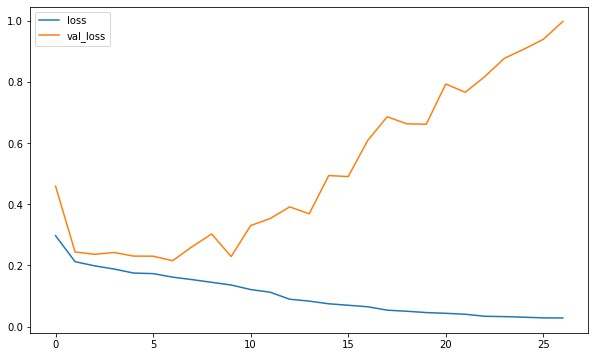

In [241]:
plt.figure(figsize = (10,6))
plt.plot(history.history['loss'],label = 'loss')
plt.plot(history.history['val_loss'],label = 'val_loss')
plt.legend()
plt.show()

# 2517 -  02.01.2020
# 2769  -  31.12.2020 это тестовый период
для обучения будем использовать данные торгов до 2020 года


In [115]:
def prep_data_3(bot): # готовит данные для подачи в сеть: по days дням и тренду равному trend
    X =[]
    Y = []
    for i in range(df.shape[0]-bot[0]-1):
        x = df.iloc[i:i+bot[0], 3:5+bot[1]]
        y = df.iloc[i+bot[0], 4+bot[1]]
        X.append(x)
        Y.append(y)
    X = np.array(X)
    Y = np.array(Y)
    #Y = to_categorical(Y,2) # это данные trend на следующем шаге (на следующий день)
    return X, Y

In [116]:
in_1,_ = prep_data_3([10,1]) # за 10 дней тренд 1
in_10,_ = prep_data_3([10,10]) # за 10 дней тренд 10
in_20,_ = prep_data_3([10,20])# за 10 дней тренд 20
in_30,Y = prep_data_3([10,30])# за 10 дней тренд 30

In [126]:
y = to_categorical(Y,2)

In [127]:
type(y)

numpy.ndarray

In [129]:
in_1.shape, in_10.shape, in_20.shape, in_30.shape, y.shape

((2851, 10, 3), (2851, 10, 12), (2851, 10, 22), (2851, 10, 32), (2851, 2))

In [120]:
inp_1 = Input(shape =(10,3))
inp_10 = Input(shape = (10,12))
inp_20 = Input(shape = (10,22))
inp_30 = Input(shape = (10,32))

conv_1 = Conv1D(32,2, activation = 'relu', padding = 'same')(inp_1)
conv_1 = Conv1D(64, 2, activation = 'relu', padding ='same')(conv_1)
conv_1 = SpatialDropout1D(0.3)(conv_1)
f_1 = Flatten()(conv_1)

conv_10 = Conv1D(32,3, activation = 'relu', padding = 'same')(inp_10)
conv_10 = Conv1D(64, 3, activation = 'relu', padding = 'same')(conv_10)
conv_10 = SpatialDropout1D(0.3)(conv_10)
f_10 = Flatten()(conv_10)

conv_20 = Conv1D(32,4, activation = 'relu', padding = 'same')(inp_20)
conv_20 = Conv1D(64, 4, activation = 'relu', padding = 'same')(conv_20)
conv_20 = SpatialDropout1D(0.3)(conv_20)
f_20 = Flatten()(conv_20)

conv_30 = Conv1D(32,5, activation = 'relu', padding = 'same')(inp_30)
conv_30 = Conv1D(64, 5, activation = 'relu', padding = 'same')(conv_30)
conv_30 = SpatialDropout1D(0.3)(conv_30)
f_30 = Flatten()(conv_30)

conc = Concatenate()([f_1, f_10, f_20, f_30])

den = Dense(128, activation = 'relu')(conc)
den = Dropout(0.3)(den)
y = Dense(2, activation = 'softmax')(den)

model = Model([inp_1, inp_10, inp_20, inp_30], y)
#model.summary()

In [73]:
model = Sequential()
model.add(Conv1D(32,3, activation = 'relu', input_shape= (10,12)))
model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dense(2, activation = 'softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_64 (Conv1D)           (None, 8, 32)             1184      
_________________________________________________________________
flatten_33 (Flatten)         (None, 256)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_23 (Dense)             (None, 2)                 258       
Total params: 34,338
Trainable params: 34,338
Non-trainable params: 0
_________________________________________________________________


In [121]:
model.compile(loss = 'categorical_crossentropy', optimizer = Adam(lr = 0.0001))

In [122]:
path = r'C:\Users\takhi\Desktop\Diploma\Regression_weights\dropout1d_weights.h5'
check = ModelCheckpoint(path, save_best_only = True, save_weights_only = True)

In [123]:
inputs = [in_1[:2517], in_10[:2517], in_20[:2517], in_30[:2517]]
val = [in_1[2517:2770], in_10[2517:2770], in_20[2517:2770], in_30[2517:2770]]
inputs_1 = [in_1[:2517], in_10[:2517]]
val_1 = [in_1[2517:2770], in_10[2517:2770]]

In [130]:
history = model.fit(inputs, y[:2517], batch_size = 1, epochs = 100,\
                   validation_data = (val, y[2517:2770]), callbacks = [check])

Epoch 1/100
2517/2517 [==============================] - 5s 2ms/step - loss: 0.3911 - val_loss: 0.2918
Epoch 2/100
2517/2517 [==============================] - 5s 2ms/step - loss: 0.2311 - val_loss: 0.3036
Epoch 3/100
2517/2517 [==============================] - 5s 2ms/step - loss: 0.1828 - val_loss: 0.2819
Epoch 4/100
2517/2517 [==============================] - 5s 2ms/step - loss: 0.1685 - val_loss: 0.2920
Epoch 5/100
2517/2517 [==============================] - 5s 2ms/step - loss: 0.1404 - val_loss: 0.3079
Epoch 6/100
2517/2517 [==============================] - 5s 2ms/step - loss: 0.1224 - val_loss: 0.3507
Epoch 7/100
2517/2517 [==============================] - 5s 2ms/step - loss: 0.1170 - val_loss: 0.3485
Epoch 8/100
2517/2517 [==============================] - 5s 2ms/step - loss: 0.0880 - val_loss: 0.3833
Epoch 9/100
2517/2517 [==============================] - 5s 2ms/step - loss: 0.0768 - val_loss: 0.3824: 0.0
Epoch 10/100
2517/2517 [==============================] - 5s 2ms/ste

In [209]:
#model.compile(loss = 'mse', optimizer = Adam(lr = 0.00001), metrics = ['accuracy'])

In [131]:
loss = history.history['loss']
accuracy = history.history['val_loss']

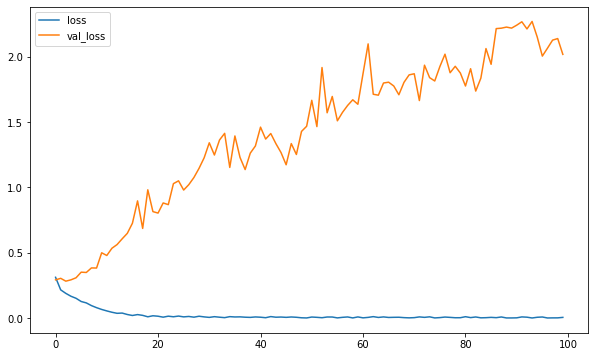

In [132]:
plt.figure(figsize = (10,6))
plt.plot(loss, label = 'loss')
plt.plot(accuracy, label = 'val_loss')
plt.legend()
plt.savefig(r'C:\Users\takhi\Desktop\Diploma\Complex_drop1D.png')
plt.show()


In [90]:
model.load_weights(path)

In [220]:
pred = model.predict(inputs)
pred_inverse = hand_inv(pred)
real = hand_inv(y_train)

In [221]:
print(*pred[60:70])
print(*y_train[60:70])

[-0.87972665] [-0.8810887] [-0.8808613] [-0.87852657] [-0.87675244] [-0.87405] [-0.8739752] [-0.8737649] [-0.87293524] [-0.87120205]
-0.8793039784638773 -0.8761335860733254 -0.8749539071460802 -0.8712674069827188 -0.8751013705277064 -0.8718572605092234 -0.8702351914370998 -0.8690555125098547 -0.8710462259731616 -0.8573324408653347


# Протестируем результаты торговли по тренду без использования НС

In [173]:
df = pd.read_csv(r'C:\Users\takhi\Desktop\Diploma\JPM.csv')# создаем таблицу пандас из загруженного файл
df.drop(['Unnamed: 0', 'High', 'Low', 'Adj Close', 'Volume'], axis =1, inplace = True)
for i in range(30):
    diff = df.Close.diff(i+1)
    df['tr_'+str(i+1)] = [1 if i >0 else 0 for i in diff]
df.head(3)

,Date,Open,Close,tr_1,tr_2,tr_3,tr_4,tr_5,tr_6,tr_7,...,tr_21,tr_22,tr_23,tr_24,tr_25,tr_26,tr_27,tr_28,tr_29,tr_30
0,2009-12-31,41.619999,41.669998,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2010-01-04,41.790001,42.849998,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2010-01-05,42.790001,43.680000,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [170]:
df_test = df[2517:2770]
df_test.shape

(253, 33)

In [174]:
df = df_test
df.shape

(253, 33)

In [175]:
def buy(tr=1):
    cash = 10000
    capital = cash
    log = pd.DataFrame()
    inventory = 0
    st_buy = []
    st_sell = []

    for i in range(len(df)):
        signal = df.iloc[i,2+tr]
        shares = cash//df.Close[i]
        if signal == 1 and shares >=1: # растущий тренд, покупать 
            inventory+=shares
            st_buy.append(i)
            cash -= shares*df.Close[i]
            capital = (inventory*df.Close[i] + cash)
            line = pd.DataFrame({'Day': [i], 'Signal': [signal], 'Cash': [cash], 'Inventory': [inventory], \
                                 'Stock_buy': [shares],'Stock_sell': [0], \
                                 'Deal_price': [df.Close[i]],'Capital': [capital]})
            log = log.append(line, ignore_index= True)
            continue
        elif signal == 1 and shares <1:
            capital = inventory*df.Close[i] + cash
            line = pd.DataFrame({'Day': [i], 'Signal': [signal], 'Cash': [cash], 'Inventory': [inventory], \
                                 'Stock_buy': [0],'Stock_sell': [0],
                                 'Deal_price': [0],'Capital': [capital]})
            log = log.append(line, ignore_index= True)
            continue
        elif signal == 0 and inventory >=1:# падающий тренд, продавать
            cash += df.Close[i]*inventory
            capital = cash
            inventory = 0
            st_sell.append(i)
            line = pd.DataFrame({'Day': [i], 'Signal': [signal], 'Cash': [cash], 'Inventory': [inventory], \
                                 'Stock_buy': [0],'Stock_sell': [inventory],\
                                 'Deal_price': [df.Close[i]],'Capital': [capital]})
            log = log.append(line, ignore_index= True)
            inventory = 0
            continue
        elif signal ==0 and inventory < 1:# падающий тренд, продавать
            line = pd.DataFrame({'Day': [i], 'Signal': [signal], 'Cash': [cash], 'Inventory': [inventory], \
                                 'Stock_buy': [0],'Stock_sell':[0],\
                                 'Deal_price': [0],'Capital': [capital]})
            log = log.append(line, ignore_index= True)
            continue
            

    return log 

In [198]:
def buy_1(data, tr=1):
    cash = 10000
    capital = cash
    log = pd.DataFrame()
    inventory = 0
    st_buy = []
    st_sell = []

    for i in range(len(df)):
        signal = data.iloc[i,2+tr]
        shares = cash//data.iloc[i,2]
        if signal == 1 and shares >=1: # растущий тренд, покупать 
            inventory+=shares
            st_buy.append(i)
            cash -= shares*data.iloc[i,2]
            capital = (inventory*data.iloc[i,2] + cash)
            line = pd.DataFrame({'Day': [i], 'Signal': [signal], 'Cash': [cash], 'Inventory': [inventory], \
                                 'Stock_buy': [shares],'Stock_sell': [0], \
                                 'Deal_price': [data.iloc[i,2]],'Capital': [capital]})
            log = log.append(line, ignore_index= True)
            continue
        elif signal == 1 and shares <1:
            capital = inventory*data.iloc[i,2] + cash
            line = pd.DataFrame({'Day': [i], 'Signal': [signal], 'Cash': [cash], 'Inventory': [inventory], \
                                 'Stock_buy': [0],'Stock_sell': [0],
                                 'Deal_price': [0],'Capital': [capital]})
            log = log.append(line, ignore_index= True)
            continue
        elif signal == 0 and inventory >=1:# падающий тренд, продавать
            cash += data.iloc[i,2]*inventory
            capital = cash
            inventory = 0
            st_sell.append(i)
            line = pd.DataFrame({'Day': [i], 'Signal': [signal], 'Cash': [cash], 'Inventory': [inventory], \
                                 'Stock_buy': [0],'Stock_sell': [inventory],\
                                 'Deal_price': [data.iloc[i,2]],'Capital': [capital]})
            log = log.append(line, ignore_index= True)
            inventory = 0
            continue
        elif signal ==0 and inventory < 1:# падающий тренд, продавать
            line = pd.DataFrame({'Day': [i], 'Signal': [signal], 'Cash': [cash], 'Inventory': [inventory], \
                                 'Stock_buy': [0],'Stock_sell':[0],\
                                 'Deal_price': [0],'Capital': [capital]})
            log = log.append(line, ignore_index= True)
            continue
            

    return log 

In [199]:
log = buy_1(df_test, 30)

In [190]:
log

,Day,Signal,Cash,Inventory,Stock_buy,Stock_sell,Deal_price,Capital
0,0,1,123.700256,70.0,70.0,0,141.089996,10000.000000
1,1,0,9807.500000,0.0,0.0,0,138.339996,9807.500000
2,2,0,9807.500000,0.0,0.0,0,0.000000,9807.500000
3,3,0,9807.500000,0.0,0.0,0,0.000000,9807.500000
4,4,0,9807.500000,0.0,0.0,0,0.000000,9807.500000
...,...,...,...,...,...,...,...,...
248,248,1,70.622162,73.0,0.0,0,0.000000,9160.581917
249,249,1,70.622162,73.0,0.0,0,0.000000,9220.441895
250,250,1,70.622162,73.0,0.0,0,0.000000,9196.352318
251,251,1,70.622162,73.0,0.0,0,0.000000,9221.902206


In [208]:
result = []
for i in range(1,31):
    log = buy_1(df_test,tr = i)
    result.append(log.iloc[-1,-1])

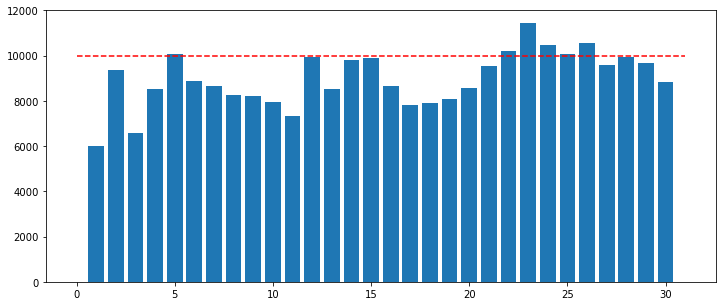

In [232]:
trend = np.arange(1,31)
plt.figure(figsize = (12,5))
plt.bar(trend, result)
plt.plot(np.arange(0,32),[10000]*32, 'r--')
plt.savefig(r'C:\Users\takhi\Desktop\Diploma\trading_bars.png')
plt.show()


# Сделайте несколько усовершенствований в предсказании временного ряда
•	Добавьте к исходному сигналу расширенные данные:
o	попарные разности каналов
o	модули попарных разностей каналов
o	попарные произведения каналов
o	обратное значение каналов x_new = 1/(x + 1e-3)
o	первые производные каналов (x[n] - x[n-1])
o	вторые производные каналов (x[n] - 2*x[n-1] + x[n-2])
•	Сделайте бОльший “просмотр сети в прошлое”, при формировании входного сигнала используйте:
o	100 точек с шагом назад по 1
o	100 точек с шагом назад по 10 (или сами точки, или среднее по отрезку в 10 точек)

In [3]:
df = pd.read_csv(r'C:\Users\takhi\Desktop\Diploma\JPM.csv')# создаем таблицу пандас из загруженного файл

In [4]:
df_2 = df.copy()

In [5]:
df_2.drop(['Unnamed: 0', 'Adj Close'], axis = 1, inplace = True)
df_2.head(3)

,Date,Open,High,Low,Close,Volume
0,2009-12-31,41.619999,42.130001,41.450001,41.669998,20143100
1,2010-01-04,41.790001,42.990002,41.669998,42.849998,35460500
2,2010-01-05,42.790001,43.840000,42.779999,43.680000,41208300


In [6]:
scaler = MinMaxScaler((-1,1))# нормализуем данные по ценам
vscaler = MinMaxScaler((-1,1)) # нормализуем данные по объему торгов
scaler.fit(df.Close.values.reshape(-1,1))
df_2['s_open'] = scaler.transform(df.Open.values.reshape(-1,1))
df_2['s_high'] = scaler.transform(df.High.values.reshape(-1,1))
df_2['s_low'] = scaler.transform(df.Low.values.reshape(-1,1))
df_2['s_close'] = scaler.transform(df.Close.values.reshape(-1,1))
df_2['s_volume'] = vscaler.fit_transform(df.Volume.values.reshape(-1,1))

In [7]:
df_2['Open_1'] = [df.Open[i] - df.High[i] for i in range(len(df_2))] # расчитываем попарную разницу каналов
df_2['Open_2'] = [df.Open[i] - df.Low[i] for i in range(len(df_2))]
df_2['Open_3'] = [df.Open[i] - df.Close[i] for i in range(len(df_2))]
df_2['High_1'] = [df.High[i] - df.Low[i] for i in range(len(df_2))]
df_2['High_2'] = [df.High[i] - df.Close[i] for i in range(len(df_2))]
df_2['Low_1']  = [df.Low[i] - df.Close[i] for i in range(len(df_2))]

In [8]:
for i in range(30):# готовим тренд от 1 до 30 шагов назад
    diff = df_2.Close.diff(i+1)
    df_2['tr_'+str(i+1)] = [1. if i >0 else 0. for i in diff]

In [9]:
df_2.drop([ 'Open', 'High', 'Low', 'Close', 'Volume'], axis = 1, inplace = True)

In [10]:
x = df_2.values
x.shape
df_2.head(3)

,Date,s_open,s_high,s_low,s_close,s_volume,Open_1,Open_2,Open_3,High_1,...,tr_21,tr_22,tr_23,tr_24,tr_25,tr_26,tr_27,tr_28,tr_29,tr_30
0,2009-12-31,-0.808199,-0.800811,-0.810662,-0.807475,-0.842793,-0.510002,0.169998,-0.049999,0.680000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2010-01-04,-0.805737,-0.788353,-0.807475,-0.790381,-0.699619,-1.200001,0.120003,-1.059998,1.320004,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2010-01-05,-0.791250,-0.776039,-0.791395,-0.778357,-0.645894,-1.049999,0.010002,-0.889999,1.060001,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
def correlation(a,b):
    ma = a.mean()
    mb = b.mean()
    mab = (a*b).mean()
    sa = a.std()
    sb = b.std()
    val = (mab - ma*mb)/(sa*sb)
    return val

In [12]:
def show_corr(a,b, step, name):# a is yVal , b is yPred
    l = len(a)
    cor = []
    auto_corr = []
    for i in range(step):
        cor.append(correlation(a[:l-i], b[i:]))
        auto_corr.append(correlation(a[:l-i], a[i:]))
        
    plt.figure(figsize = (12,5))
    plt.plot(cor, label = 'корреляция')
    plt.plot(auto_corr, label = 'эталон')
    plt.legend(fontsize = 'xx-large')
    plt.title('Корреляция модели %s ' % (name)+ 'на '+ str(step)+ ' шагах')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.savefig(r'C:\Users\takhi\Desktop\Diploma\Result_figures\%s' %(name) + ' correlation.png')
    plt.legend()
    plt.show()

In [13]:
def prep_data_1(data, win, trend):# для подготовки данных вручную
    x_tr = []
    y_tr = []
    l = len(data)
    for i in range(l-win-1):
        x = data.values[i:i+win,1: 11+trend+1]
        y = data.values[i+win+1,4]
        x_tr.append(x)
        y_tr.append(y)
    x_tr = np.array(x_tr).astype('float64')
    y_tr = np.array(y_tr).astype('float64')
    return x_tr, y_tr       

In [14]:
xLen = 10 # берем наборы данных за 10 дней
valLen = 250 #размер данных, которые не попадут в тренировочный генератор
trainLen = df_2.shape[0] - valLen
xTrain, xTest = df_2.values[:trainLen,1:].astype('float64'), df_2.values[trainLen +xLen + 2:,1:].astype('float64')
yTrain, yTest = df_2.s_close.values[:trainLen].astype('float64'), df_2.s_close.values[trainLen +xLen +2:].astype('float64')

In [15]:
len(yTrain), len(xTrain), len(xTest), len(yTest)

(2626, 2626, 238, 238)

In [16]:
print(*df_2.columns[1:].tolist())# такие данные будут подаваться в НС
print()

s_open s_high s_low s_close s_volume Open_1 Open_2 Open_3 High_1 High_2 Low_1 tr_1 tr_2 tr_3 tr_4 tr_5 tr_6 tr_7 tr_8 tr_9 tr_10 tr_11 tr_12 tr_13 tr_14 tr_15 tr_16 tr_17 tr_18 tr_19 tr_20 tr_21 tr_22 tr_23 tr_24 tr_25 tr_26 tr_27 tr_28 tr_29 tr_30



In [18]:
trainDatagen = TimeseriesGenerator(xTrain, yTrain, length = xLen, batch_size = 1)
testDatagen = TimeseriesGenerator(xTest, yTest, length = xLen, batch_size = 1)

In [47]:
xVal = [] # для проверки результатов работы модели и построения графиков
yVal = []
for i in testDatagen:
    xVal.append(i[0])
    yVal.append(i[1])
xVal = np.array(xVal)
yVal = np.array(yVal)
yValunscaled = scaler.inverse_transform(yVal)

In [97]:
len(xVal), len(yVal), xVal.shape

(228, 228, (228, 1, 10, 41))

In [20]:
yValunscaled[:5]

array([[ 96.26999664],
       [ 97.65000153],
       [ 98.20999908],
       [ 99.73000336],
       [100.01000214]])

In [21]:
trainDatagen[0][0].shape

(1, 10, 41)

In [22]:
x,y = prep_data(df_2,10,30)

In [23]:
x[0].dtype

dtype('float64')

In [45]:
# для подготовки данных вручную
win = 10 # за сколько дней берем данные 
l = len(x)
val_len = 250 #оставляем для подготовки валидационной выборки
x_tr, y_tr = x[:l-val_len].astype('float64'), y[:l-val_len].astype('float64')
xVal, yVal = x[(l-val_len)+win+2:].astype('float64'),y[(l-val_len)+win+2:].astype('float64')

In [46]:
len(xVal), len(yVal)

(238, 238)

In [25]:
x_tr.shape, y_tr.shape

((2615, 10, 41), (2615,))

# Простая модель

In [26]:
model = Sequential()
model.add(Dense(150, input_shape = (10, 41), activation = 'relu'))
model.add(Flatten())
model.add(Dense(1, activation = 'linear'))
model.compile(loss = 'mse', optimizer = Adam(lr =0.0001))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10, 150)           6300      
_________________________________________________________________
flatten (Flatten)            (None, 1500)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1501      
Total params: 7,801
Trainable params: 7,801
Non-trainable params: 0
_________________________________________________________________


In [ ]:
result = model.fit(trainDatagen, epochs = 50,validation_data = testDatagen)
clear_output()

# Функции для визуализации результатов

In [55]:
def show_result(xVal, yVal, model, step, name):
    pred = model.predict(xVal)
    prediction = []
    for i in pred:
        prediction.append(np.argmax(i))
    plt.figure(figsize = (12,5))
    plt.plot(yVal[:step], label = 'Реальное значение', )
    plt.plot(prediction[:step],'r--', label = 'Предсказание модели')
    plt.legend(fontsize = 'xx-large')
    plt.title('Предсказание модели %s на '%(name) + str(step)+ ' шагах')
    plt.xlabel('Время')
    plt.ylabel('Значение')
    plt.savefig(r'C:\Users\takhi\Desktop\Diploma\Result_figures\%s' %(name) + ' result.png')
    plt.show()

In [21]:
def show_loss(result, name):# отображение динамики loss и val_loss
    plt.figure(figsize = (12,5))
    plt.plot(result.history['loss'], label = 'loss', )
    plt.plot(result.history['val_loss'],'r--', label = 'validation loss')
    plt.legend(fontsize = 'xx-large')
    plt.title('Ошибка модели %s ' %(name))
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.savefig(r'C:\Users\takhi\Desktop\Diploma\Result_figures\%s' %(name) + ' loss.png')
    plt.show()

In [22]:
def show_accuracy(result, name):# отображение динамики loss и val_loss
    plt.figure(figsize = (12,5))
    plt.plot(result.history['accuracy'], label = 'accuracy', )
    plt.plot(result.history['val_accuracy'],'r--', label = 'validation accuracy')
    plt.legend(fontsize = 'xx-large')
    plt.title('Точность модели %s ' %(name))
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.savefig(r'C:\Users\takhi\Desktop\Diploma\Result_figures\%s' %(name) + ' accuracy.png')
    plt.show()

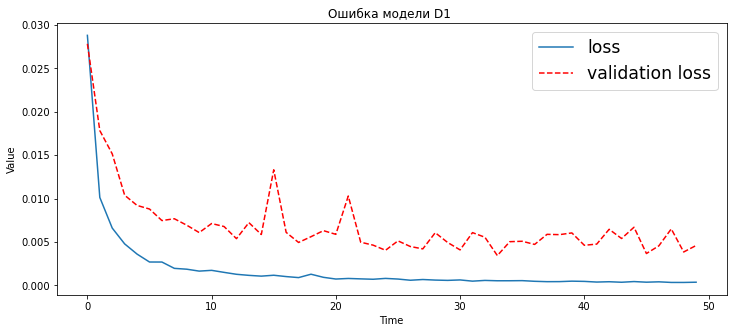

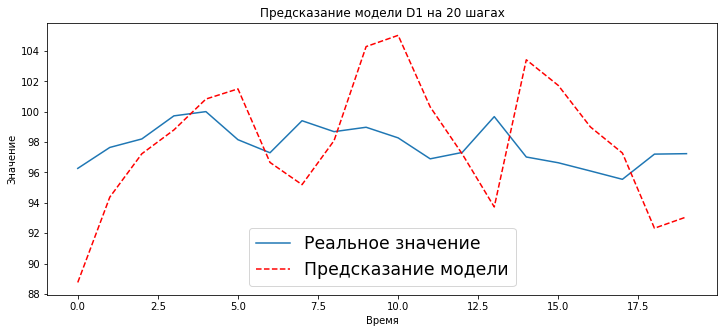

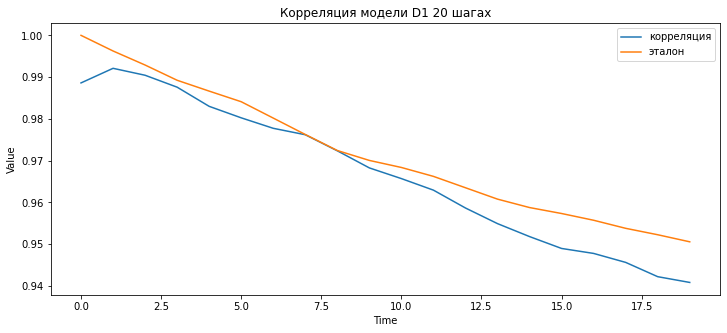

In [85]:
a = yValunscaled
b = scaler.inverse_transform(model.predict(xVal))
show_loss(result, 'D1')
show_result(a,b,20, 'D1')
show_corr(a,b,20,'D1')

# Простая модель 2

In [94]:
model = Sequential()
model.add(Flatten(input_shape = (10,41)))
model.add(Dense(150, activation = 'relu'))
model.add(Dense(1, activation = 'linear'))
model.summary()
model.compile(loss = 'mse', optimizer = Adam(lr =0.0001))

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_8 (Flatten)          (None, 410)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 150)               61650     
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 151       
Total params: 61,801
Trainable params: 61,801
Non-trainable params: 0
_________________________________________________________________


In [ ]:
result = model.fit(trainDatagen, epochs=50, validation_data = testDatagen)

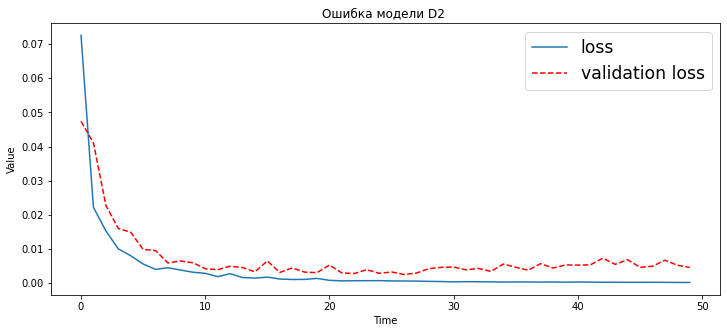

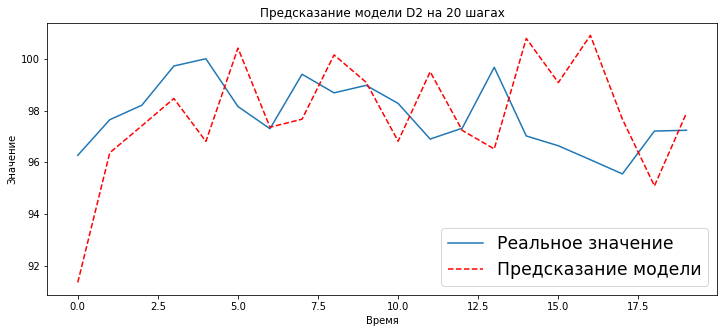

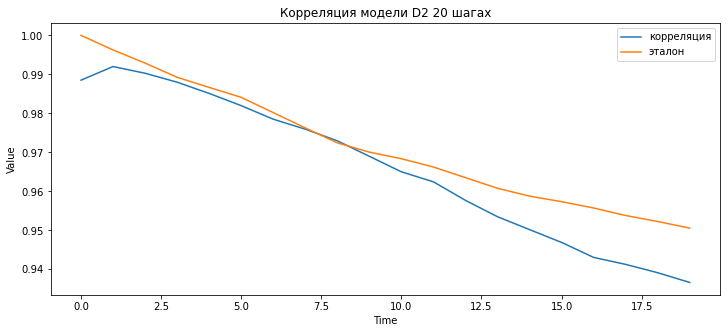

In [100]:
a = yValunscaled
b = scaler.inverse_transform(model.predict(xVal.reshape(-1,10,41)))
show_loss(result, 'D2')
show_result(a,b,20, 'D2')
show_corr(a,b,20,'D2')

# Сверточная модель 2

In [108]:
def conv1d_model(shape):
    inp = Input((shape))
    con = Conv1D(64, 5, activation = 'relu', padding = 'same')(inp)
    con = Conv1D(64,5,activation = 'relu',  padding = 'same')(con)
    maxp = MaxPooling1D()(con)
    flat = Flatten()(maxp)
    dense = Dense(100, activation = 'relu')(flat)
    res = Dense(1, activation = 'linear')(dense)
    model = Model(inp,res)
    return model

In [109]:
model = conv1d_model((10,41))

In [111]:
model.compile(loss = 'mse', optimizer = Adam(lr=1e-04))

In [ ]:
result = model.fit(trainDatagen, epochs = 50, validation_data = testDatagen)

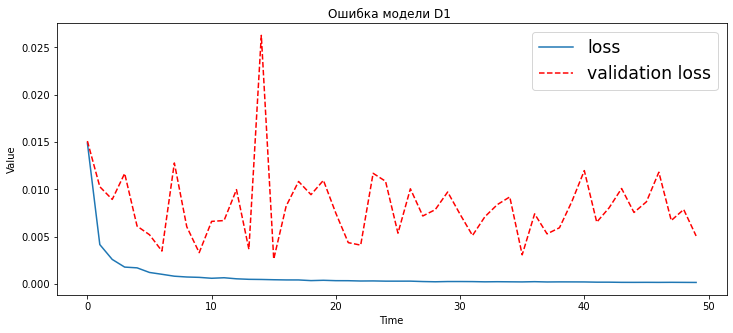

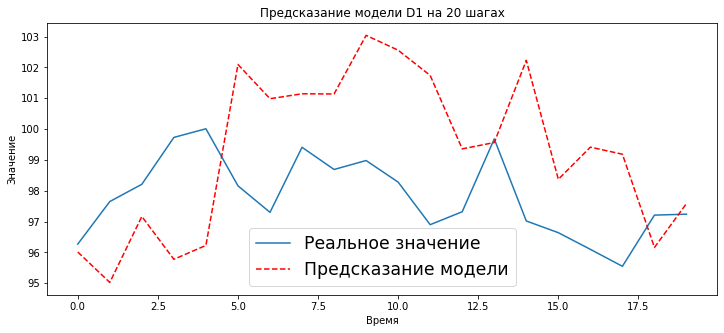

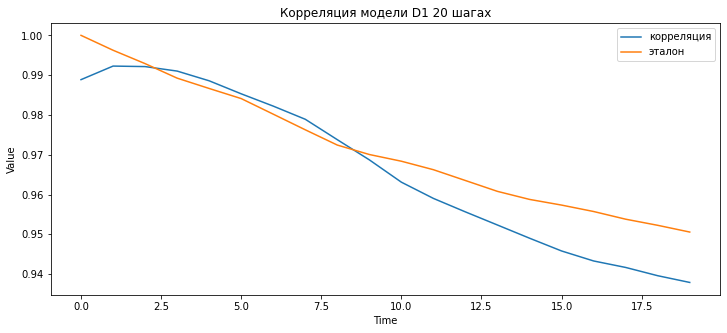

In [114]:
a = yValunscaled
b = scaler.inverse_transform(model.predict(xVal.reshape(-1,10,41)))
show_loss(result, 'C1')
show_result(a,b,20, 'C1')
show_corr(a,b,20,'C1')

In [23]:
#------------------------------------------- БЛОК ПОДГОТОВКИ ДАННЫХ  ----------------------------------------------------
def prep_data(xLen, valLen, batch_size=1):
    
    xLen = xLen # берем наборы данных за 10 дней
    valLen = valLen #размер данных, которые не попадут в тренировочный генератор
    trainLen = df_2.shape[0] - valLen
    xTrain, xTest = df_2.values[:trainLen,1:].astype('float64'), df_2.values[trainLen +xLen + 2:,1:].astype('float64')
    yTrain, yTest = df_2.s_close.values[:trainLen].astype('float64'), df_2.s_close.values[trainLen +xLen +2:].astype('float64')

    # формируем генераторы
    trainDatagen = TimeseriesGenerator(xTrain, yTrain, length = xLen, batch_size = 1)
    testDatagen = TimeseriesGenerator(xTest, yTest, length = xLen, batch_size = 1)

    xVal = [] # для проверки результатов работы модели и построения графиков
    yVal = []
    for i in testDatagen:
        xVal.append(i[0])
        yVal.append(i[1])
    xVal = np.array(xVal).reshape(-1, xLen, 41)
    yVal = np.array(yVal)
    yValunscaled = scaler.inverse_transform(yVal)
    
    return trainDatagen, testDatagen, xVal, yValunscaled

In [129]:
trainDatagen, testDatagen, xVal, yValunscaled = prep_data(20,250)

In [130]:
for i in trainDatagen:
    pass
print(i[0].shape)

(1, 20, 41)


In [131]:
model = conv1d_model((20,41))

In [132]:
model.compile(loss = 'mse', optimizer = Adam(lr=1e-04))

In [ ]:
result = model.fit(trainDatagen, epochs = 50, validation_data = testDatagen)
clear_output()

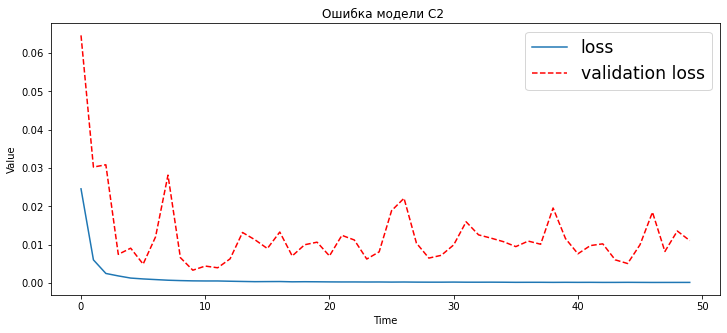

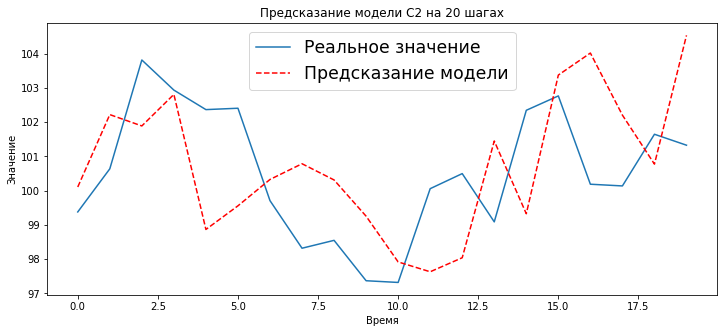

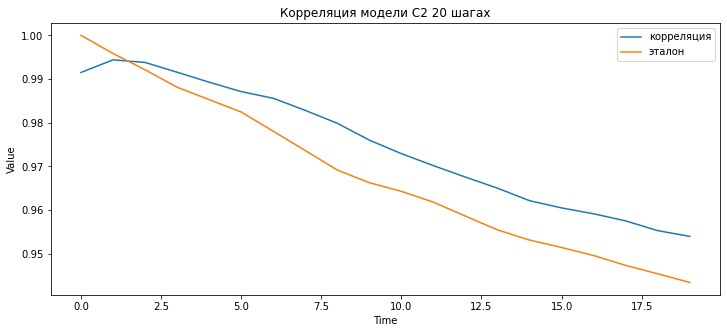

In [134]:
a = yValunscaled
b = scaler.inverse_transform(model.predict(xVal.reshape(-1,20,41)))
show_loss(result, 'C2')
show_result(a,b,20, 'C2')
show_corr(a,b,20,'C2')

In [16]:
def conv1d_model_drop(shape):
    inp = Input((shape))
    con = Conv1D(64, 5, activation = 'relu', padding = 'same')(inp)
    con = Conv1D(64,5,activation = 'relu',  padding = 'same')(con)
    drop = SpatialDropout1D(0.3)(con)
    maxp = MaxPooling1D()(drop)
    flat = Flatten()(maxp)
    dense = Dense(100, activation = 'relu')(flat)
    res = Dense(1, activation = 'linear')(dense)
    model = Model(inp,res)
    return model

In [18]:
model = conv1d_model_drop((20,41))

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20, 41)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 20, 64)            13184     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 20, 64)            20544     
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 20, 64)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 10, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 640)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               64100 

In [137]:
model.compile(loss = 'mse', optimizer = Adam(lr=1e-04))

In [ ]:
result = model.fit(trainDatagen, epochs=50, validation_data = testDatagen)
clear_output()

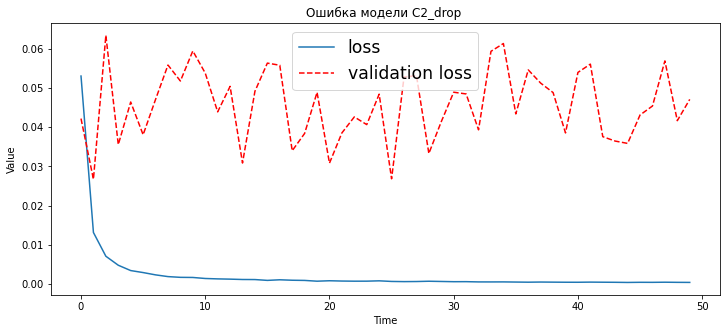

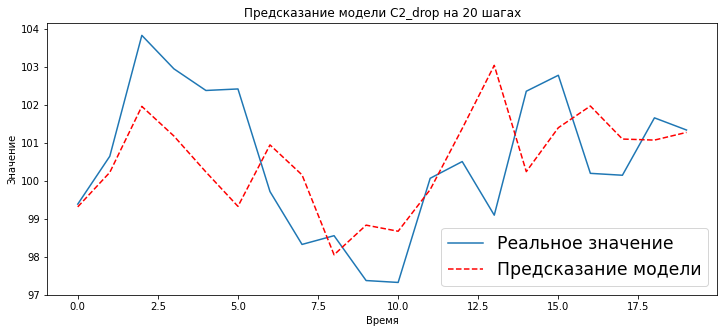

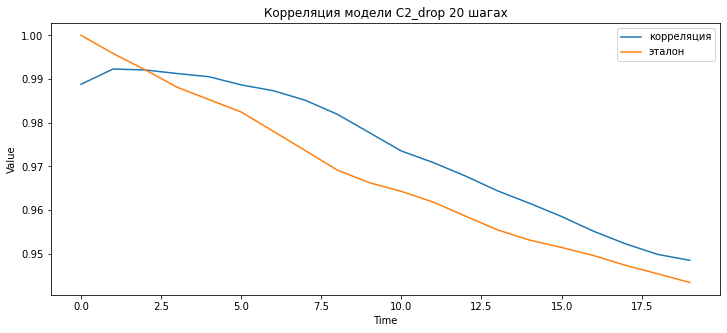

In [139]:
a = yValunscaled
b = scaler.inverse_transform(model.predict(xVal.reshape(-1,20,41)))
show_loss(result, 'C2_drop')
show_result(a,b,20, 'C2_drop')
show_corr(a,b,20,'C2_drop')

# LSTM модель 

In [52]:
def lstm_model(shape):
    inp = Input((shape))
    l = LSTM(5, activation = 'relu')(inp)
    flat = Flatten()(l)
    dense = Dense(100, activation = 'relu')(flat)
    res = Dense(1, activation = 'linear')(dense)
    model = Model(inp,res)
    return model

In [53]:
model = lstm_model((10,41))

In [54]:
model.compile(loss = 'mse', optimizer = Adam(lr=1e-04))

In [55]:
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 10, 41)]          0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 5)                 940       
_________________________________________________________________
flatten_7 (Flatten)          (None, 5)                 0         
_________________________________________________________________
dense_12 (Dense)             (None, 100)               600       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 101       
Total params: 1,641
Trainable params: 1,641
Non-trainable params: 0
_________________________________________________________________


In [147]:
trainDatagen, testDatagen, xVal, yValunscaled = prep_data(10,250)

In [ ]:
result = model.fit(trainDatagen, epochs = 30, validation_data = testDatagen)
clear_output()

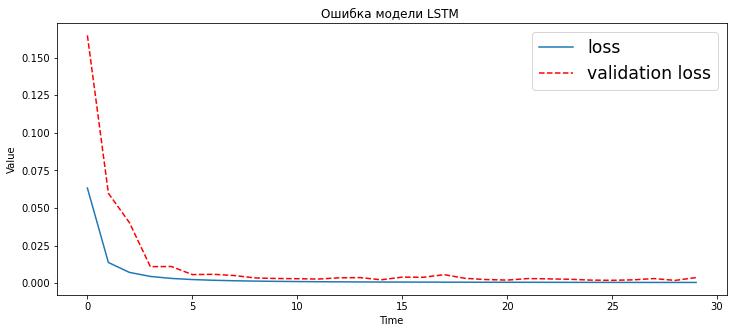

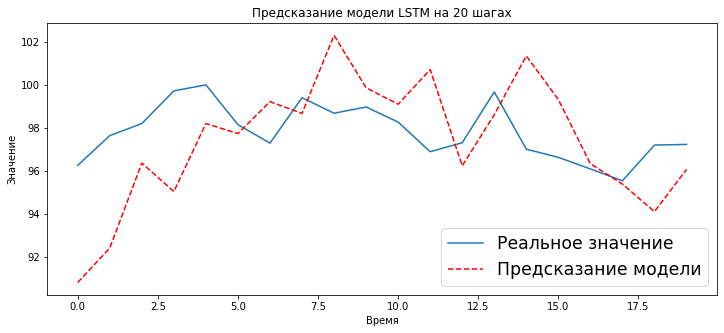

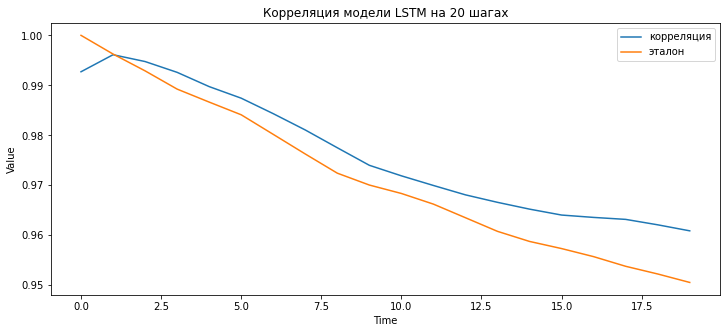

In [150]:
a = yValunscaled
b = scaler.inverse_transform(model.predict(xVal.reshape(-1,10,41)))
show_loss(result, 'LSTM')
show_result(a,b,20, 'LSTM')
show_corr(a,b,20,'LSTM')

# Предсказание тренда

In [24]:
#-------------------------------- БЛОК ПОДГОТОВКИ ДАННЫХ С ПЕРЕВОДОМ В  ONE HOT ENCODING  ----------------------------------------------------
def prep_data01(xLen, valLen, trend, step=1, batch_size=1): # trend - на каком тренде будем обучать модель,
    #step на сколько шагов вперед делаем предсказание
    
    # xLen берем наборы данных за 10 дней
    # valLen размер данных, которые не попадут в тренировочный генератор
    trainLen = df_2.shape[0] - valLen
    xTrain, xTest = df_2.values[:trainLen,1:12 + trend].astype('float64'), df_2.values[trainLen +xLen + 2:,1:12+trend].astype('float64')
    yTrain, yTest = df_2.values[:trainLen, 12 + trend].astype('float64'), df_2.values[trainLen +xLen +2:,12 + trend].astype('float64')
    yTrain, yTest = to_categorical(yTrain,2),to_categorical(yTest,2)# переводим в ohe
    # формируем генераторы
    trainDatagen = TimeseriesGenerator(xTrain, yTrain, length = xLen, sampling_rate = step, batch_size = 1)
    testDatagen = TimeseriesGenerator(xTest, yTest, length = xLen, sampling_rate = step, batch_size = 1)

    xVal = [] # для проверки результатов работы модели и построения графиков
    yVal = []
    shape_2 = 11+trend
    for i in testDatagen:
        xVal.append(i[0])
        yVal.append(np.argmax(i[1]))
    xVal = np.array(xVal).reshape(-1, xLen, shape_2)
    yVal = np.array(yVal)
    
    return trainDatagen, testDatagen, xVal, yVal

In [67]:
trainDatagen, testDatagen, xVal, yVal = prep_data01(10,250,12)

In [68]:
xVal.shape

(228, 10, 23)

In [16]:
def create_model_2(shape):
    inp = Input((shape))
    conv = Conv1D(32,5, padding = 'same', activation = 'relu')(inp)
    conv = Conv1D(64,5, padding = 'same', activation = 'relu')(conv)
    pul = MaxPooling1D()(conv)
    conv = Conv1D(128,5, padding = 'same', activation = 'relu')(pul)
    flat = Flatten()(conv)
    den = Dense(128, activation = 'linear')(flat)
    den = Dropout(0.3)(den)
    out = Dense(2, activation = 'sigmoid')(den)
    model = Model(inp,out)
    model.compile(loss='binary_crossentropy', optimizer = Adam(lr= 0.0001), metrics = ['accuracy'])
    return model

In [25]:
def show_failure(xVal,yVal, model_name):
    a = yVal
    b = []
    for i in model.predict(xVal):
        b.append(np.argmax(i))
    
    m = 0
    m_distr = []
    for i in range(len(a)):
        if a[i] != b[i]:
            m +=1
        if i>0 and i%100 == 0:
            m_distr.append(m)

    first = m_distr[0] 
    second = m_distr[1] - m_distr[0]
    last = m - m_distr[1]
    print('\t\tРЕЗУЛЬТАТ РАБОТЫ МОДЕЛИ ', model_name)
    print('----------------------------------------------------------------')
    print('Общий процент ошибки:', round((m/len(a))*100,2), '%')
    print('Процент ошибки на первых 100 шагах:', first, '%')
    print('Процент ошибки на вторых 100 шагах:', second, '%')
    print('Процент ошибки на последних 28 шагах:', round(last/28*100,2), '%')
    print('----------------------------------------------------------------\n')
    
    fail =[]
    f = 0
    for i in range(len(a)):
        if a[i]!= b[i]:
            f+=1
        fail.append(f)
    plt.plot(fail, label = 'накопленное количество неверных прогнозов')
    plt.legend()
    plt.xlabel('шаг')
    plt.ylabel('накоплено ошибок')
    plt.show()

In [70]:
model = create_model_2((10,23))

In [ ]:
result = model.fit(trainDatagen, epochs = 50, validation_data = testDatagen)

		РЕЗУЛЬТАТ РАБОТЫ МОДЕЛИ  Conv1d_tr12
----------------------------------------------------------------
Общий процент ошибки 14.47 %
Процент ошибки на первых 100 шагах 12 %
Процент ошибки на вторых 100 шагах 16 %
Процент ошибки на последних 28 шагах 17.86 %
----------------------------------------------------------------



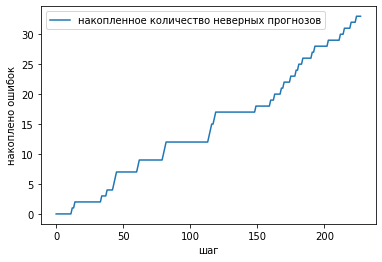

In [82]:
show_failure(yVal,xVal, 'Conv1d_tr12')

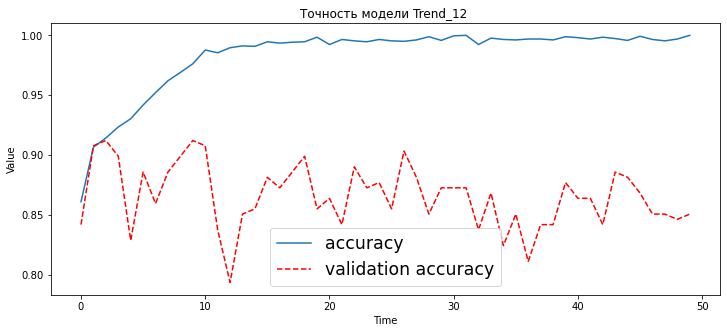

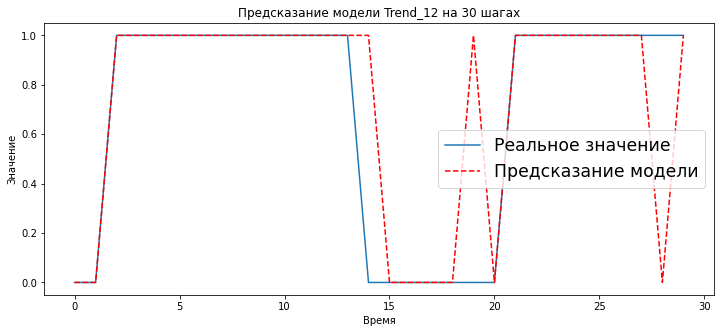

In [193]:
a = yVal
b = []
for i in model.predict(xVal):
    b.append(np.argmax(i))
show_accuracy(result, 'Trend_12')
show_result(a,b,30, 'Trend_12')

In [113]:
def create_lstm_2(shape,lstm,dense, dropout):
    inp = Input((shape))
    lstm = LSTM(lstm)(inp)
    flat = Flatten()(lstm)
    den = Dense(dense, activation = 'linear')(flat)
    den = Dropout(dropout)(den)
    out = Dense(2, activation = 'sigmoid')(den)
    model = Model(inp,out)
    model.compile(loss='binary_crossentropy', optimizer = Adam(lr= 1e-04), metrics = ['accuracy'])
    return model

In [126]:
def callback(model_name):
    
    checkpoint_filepath = r'‪C:\Users\takhi\Desktop\Diploma\LSTM_weights{}'.format(model_name)

    model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,\
    save_weights_only=True, monitor='val_accuracy',  mode='max', save_best_only=True)
    return model_checkpoint_callback

In [63]:
model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 10, 23)]          0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 5)                 580       
_________________________________________________________________
flatten_9 (Flatten)          (None, 5)                 0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               768       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 258       
Total params: 1,606
Trainable params: 1,606
Non-trainable params: 0
_________________________________________________________

In [ ]:
result  = model.fit(trainDatagen,epochs = 50, validation_data = testDatagen)

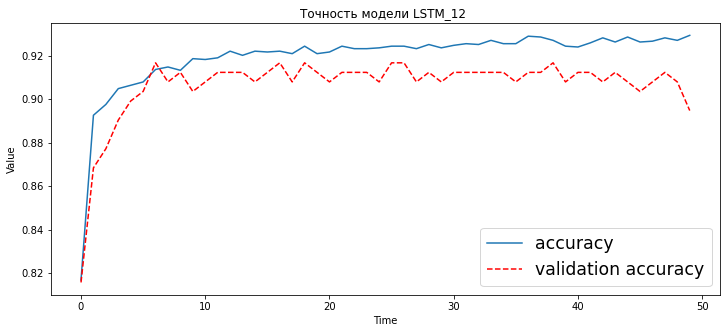

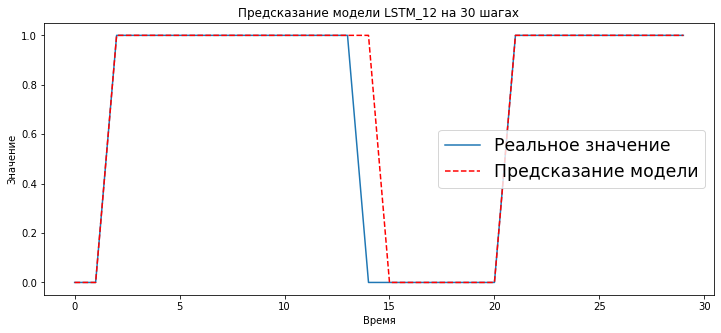

In [223]:
a = yVal
b = []
for i in model.predict(xVal):
    b.append(np.argmax(i))
show_accuracy(result, 'LSTM_12')
show_result(a,b,30, 'LSTM_12')

----------------------------------------------------------------
Общий процент ошибки 10.53 %
Процент ошибки на первых 100 шагах 9 %
Процент ошибки на вторых 100 шагах 14 %
Процент ошибки на последних 28 шагах 3.57 %
----------------------------------------------------------------



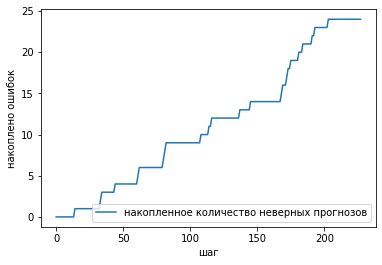

In [228]:
show_failure(a,b)

In [40]:
path = r'C:\Users\takhi\Desktop\Diploma\Conv1D_weights\eval_conv1d.h5'
checkpoint = ModelCheckpoint(filepath=path, save_weights_only=True,\
                            monitor='val_accuracy', mode='max', save_best_only=True)

reduce = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience= 5, verbose=0, mode="auto",
    min_delta=0.0001, cooldown=0, min_lr=1e-07)

stop = EarlyStopping(monitor="val_loss", min_delta=0, patience=20,\
                     verbose=0, mode="auto", baseline=None, restore_best_weights=True)

In [127]:
#ПРОБУЮ ЕЩЕ ОДНУ ЛСТМ МОДЕЛЬ С БОЛЬШИМ ЧИСЛОМ НЕЙРОНОВ
my_callback = callback('lstm_12/128/04')
model = create_lstm_2((10,23),12,128,0.4)

In [19]:
model_name = 'eval_conv1d'
checkpoint_filepath = r'C:\Users\takhi\Desktop\Diploma\Conv1D_weights\eval_conv1d.h5'

my_callback = ModelCheckpoint(filepath=checkpoint_filepath,\
save_weights_only=True, monitor='val_accuracy',  mode='max', save_best_only=True)


In [146]:
result = model.fit(trainDatagen, epochs = 50, validation_data=testDatagen, callbacks = [checkpoint])
clear_output()

		РЕЗУЛЬТАТ РАБОТЫ МОДЕЛИ  LSTM_12/128/04
----------------------------------------------------------------
Общий процент ошибки 10.09 %
Процент ошибки на первых 100 шагах 8 %
Процент ошибки на вторых 100 шагах 14 %
Процент ошибки на последних 28 шагах 3.57 %
----------------------------------------------------------------



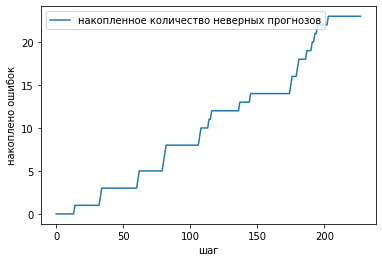

In [151]:
show_failure(xVal,yVal, 'LSTM_12/128/04')

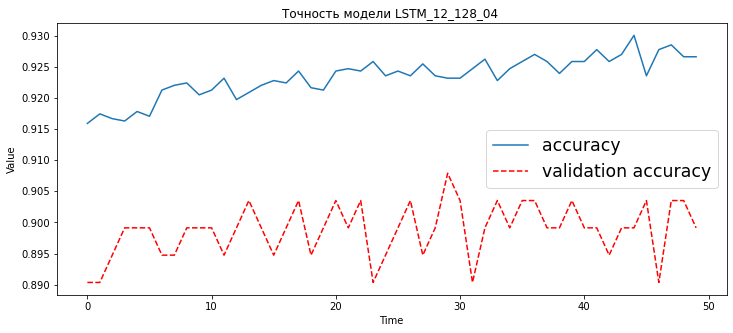

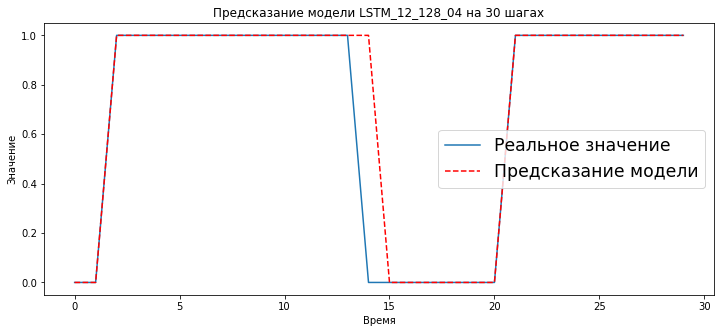

In [159]:
a = yVal
b = []
for i in model.predict(xVal):
    b.append(np.argmax(i))
show_accuracy(result, 'LSTM_12_128_04')
show_result(a,b,30, 'LSTM_12_128_04')

# Опять используем генетический алгоритм для подбора подаваемых в сеть данных

In [22]:
df_2.iloc[:,12]

0       0.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
2871    0.0
2872    1.0
2873    1.0
2874    1.0
2875    1.0
Name: tr_1, Length: 2876, dtype: float64

In [59]:
#-------------------------------- БЛОК ПОДГОТОВКИ ДАННЫХ С ПЕРЕВОДОМ В  ONE HOT ENCODING  ----------------------------------
# будем предсказывать тренд на выбранном шаге
def prep_data_01tr(xLen, trend, valLen = 250, step=1, batch_size=1): # trend - на каком тренде будем обучать модель,
    #step на сколько шагов вперед делаем предсказание
    #xLen количество дней берем наборы данных за 10 дней
    #valLen размер данных, которые не попадут в тренировочный генератор
    trainLen = df_2.shape[0] - valLen
    xTrain, xTest = df_2.values[:trainLen,1:11 + trend].astype('float32'), df_2.values[trainLen +xLen + 2:,1:11+trend].astype('float32')
    yTrain, yTest = df_2.values[:trainLen, 11 + trend].astype('float32'), df_2.values[trainLen +xLen +2:,11 + trend].astype('float32')
    yTrain, yTest = to_categorical(yTrain,2),to_categorical(yTest,2)# переводим в ohe
    # формируем генераторы
    trainDatagen = TimeseriesGenerator(xTrain, yTrain, length = xLen, sampling_rate = step, batch_size = 1)
    testDatagen = TimeseriesGenerator(xTest, yTest, length = xLen, sampling_rate = step, batch_size = 1)

    xVal = [] # для проверки результатов работы модели и построения графиков
    yVal = []
    shape_2 = 10+trend
    for i in testDatagen:
        xVal.append(i[0])
        yVal.append(np.argmax(i[1]))
    xVal = np.array(xVal).reshape(-1, xLen, shape_2)
    yVal = np.array(yVal)
    
    return trainDatagen, testDatagen, xVal, yVal

In [44]:
#-------------------------------- БЛОК ПОДГОТОВКИ ДАННЫХ С ПЕРЕВОДОМ В  ONE HOT ENCODING  ----------------------------------
# будем предсказывать тренд на следующий день по tr_1 
def prep_data01(xLen, trend, valLen = 250, step=1, batch_size=1): # trend - на каком тренде будем обучать модель,
    #step на сколько шагов вперед делаем предсказание
    #xLen количество дней берем наборы данных за 10 дней
    #valLen размер данных, которые не попадут в тренировочный генератор
    trainLen = df_2.shape[0] - valLen
    xTrain, xTest = df_2.values[:trainLen,1:11 + trend].astype('float32'), df_2.values[trainLen +xLen + 2:,1:11+trend].astype('float32')
    yTrain, yTest = df_2.values[:trainLen, 12].astype('float32'), df_2.values[trainLen +xLen +2:,12].astype('float32')
    yTrain, yTest = to_categorical(yTrain,2),to_categorical(yTest,2)# переводим в ohe
    # формируем генераторы
    trainDatagen = TimeseriesGenerator(xTrain, yTrain, length = xLen, sampling_rate = step, batch_size = 1)
    testDatagen = TimeseriesGenerator(xTest, yTest, length = xLen, sampling_rate = step, batch_size = 1)

    xVal = [] # для проверки результатов работы модели и построения графиков
    yVal = []
    shape_2 = 10+trend
    for i in testDatagen:
        xVal.append(i[0])
        yVal.append(np.argmax(i[1]))
    xVal = np.array(xVal).reshape(-1, xLen, shape_2)
    yVal = np.array(yVal)
    
    return trainDatagen, testDatagen, xVal, yVal

In [19]:
trainDatagen, testDatagen, xVal, yVal = prep_data01(10, 30)
xVal.shape, yVal.shape

((228, 10, 40), (228,))

In [205]:
def create_lstm_test(i):
    inp = Input((xVal.shape[1], xVal.shape[2]))
    lstm = LSTM(i)(inp)
    flat = Flatten()(lstm)
    den = Dense(128, activation = 'linear')(flat)
    den = Dropout(0.3)(den)
    out = Dense(2, activation = 'sigmoid')(den)
    model = Model(inp,out)
    model.compile(loss='binary_crossentropy', optimizer = Adam(lr= 1e-04), metrics = ['accuracy'])
    return model

In [187]:
# ------------------------- подбираем оптимальное число нейронов в лстм слое ------------------------------------
net_acc = []
for i in range(5,21):
    model = create_lstm_test(i)
    result = model.fit(trainDatagen, epochs = 6, validation_data = testDatagen, verbose = 0)
    v = result.history['val_accuracy'][-1]
    net_acc.append(v)
m = max(net_acc)
lstm = net_acc.index(m)
print(net_acc, lstm)

[0.8859649300575256, 0.8815789222717285, 0.8684210777282715, 0.8947368264198303, 0.8684210777282715, 0.890350878238678, 0.890350878238678, 0.8815789222717285, 0.8640350699424744, 0.890350878238678, 0.890350878238678, 0.8947368264198303, 0.890350878238678, 0.8771929740905762, 0.9035087823867798, 0.8728070259094238] 14


In [21]:
def create_lstm_3():
    inp = Input((xVal.shape[1], xVal.shape[2]))
    lstm = LSTM(18)(inp)
    flat = Flatten()(lstm)
    den = Dense(128, activation = 'linear')(flat)
    den = Dropout(0.3)(den)
    out = Dense(2, activation = 'sigmoid')(den)
    model = Model(inp,out)
    model.compile(loss='binary_crossentropy', optimizer = Adam(lr= 1e-04), metrics = ['accuracy'])
    return model

In [61]:
def create_bot(): # a = timesteps, b =trend
    bot = []
    bot.append(random.randint(2,20))
    bot.append(random.randint(1,30))
    return bot

In [62]:
def evaluate(epochs = 5, verb = 0):
    history = model.fit(trainDatagen, epochs = epochs, batch_size= 1, verbose = verb,\
                       validation_data = testDatagen)
    val = history.history['val_accuracy'][-1]
    return val

In [58]:
n = 20                    # Общее число ботов
nsurv = 5                 # Количество выживших (столько лучших переходит в новую популяцию)
nnew = n - nsurv          # Количество новых (столько новых ботов создается)
l = 2                     # Размер бота
epohs = 15                # количество эпох
mut = 0.3                 # коэфициент мутаций
popul = []                # Массив популяции
val = []   

for i in range(n):
    b = create_bot()
    popul.append(b)
  
for it in range(epohs):   # Пробегаем по всем эпохам
    val = []                # Обнуляем значения бота
    curr_time = time.time()
    for i in tqdm(range(n)):      # Пробегаем в цикле по всем ботам 
        bot = popul[i]        # Берем очередного бота
        trainDatagen, testDatagen, xVal, yVal = prep_data01(bot[0], bot[1], step=1, batch_size=1)
        model = create_lstm_3()
        v = evaluate(epochs = 5, verb = 0)
        val.append(v)         # Добавляем полученное значение в список val
    # Сортируем val
    sval = sorted(val, reverse=0) 
    print('Эпоха ', it, round((time.time() - curr_time)/60,2),  "мин  |", sval[0:5], popul[:5]) 
    
    newpopul = []                         # Создаем пустой список под новую популяцию
    for i in range(nsurv):                # Пробегаем по всем выжившим ботам
        index = val.index(sval[i])          # Получаем индекс очередного бота из списка лучших в списке val
        newpopul.append(popul[index])       # Добавляем в новую популяцию бота из popul с индексом index

    for i in range(nnew):                 # Проходимся в цикле nnew-раз  
        indexp1 = random.randint(0,nsurv-1) # Случайный индекс первого родителя в диапазоне от 0 до nsurv - 1
        indexp2 = random.randint(0,nsurv-1) # Случайный индекс первого родителя в диапазоне от 0 до nsurv - 1
        botp1 = newpopul[indexp1]           # Получаем первого бота-родителя по indexp1
        botp2 = newpopul[indexp2]           # Получаем второго бота-родителя по indexp2    
        newbot = []                         # Создаем пустой список под значения нового бота    
        for j in range(l):                  # Пробегаем по всей длине размерности          
            pindex = random.random()          # Получаем случайное число в диапазоне от 0 до 1
      # Если pindex меньше 0.5, то берем значения от первого бота, иначе от второго
            if pindex < 0.5:
                x = botp1[j]
            else:
                x = botp2[j]
            # С вероятностью mut устанавливаем значение бота случайным образом
            if (random.random() < mut):
                x = create_bot()[j]
            
            newbot.append(x)                  # Добавляем очередное значение в нового бота      
        newpopul.append(newbot)             # Добавляем бота в новую популяцию      
    mut*=mut*0.98
    popul = newpopul     

  0%|          | 0/20 [00:00<?, ?it/s]

NameError: name 'create_lstm_3' is not defined

In [14]:
def create_evalconv1d():
    inp = Input((xVal.shape[1], xVal.shape[2]))
    conv = Conv1D(32,5, padding = 'same', activation = 'relu')(inp)
    conv = Conv1D(64,5, padding = 'same', activation = 'relu')(conv)
    pul = MaxPooling1D()(conv)
    conv = Conv1D(128,5, padding = 'same', activation = 'relu')(pul)
    flat = Flatten()(conv)
    den = Dense(128, activation = 'linear')(flat)
    den = Dropout(0.3)(den)
    out = Dense(2, activation = 'sigmoid')(den)
    model = Model(inp,out)
    model.compile(loss='binary_crossentropy', optimizer = Adam(lr= 0.0001), metrics = ['accuracy'])
    return model

In [26]:
def data_selection_dense(n_bot, nsurv, l_bot, mut, epochs):
    nnew = n_bot - nsurv# nnew = n- nsurv Количество новых (столько новых ботов создается)
    l = l_bot           # l - Размер бота
    popul = []          # Массив популяции
    val = []            # список с данными точности модели по каждому боту
                        # eval_model - модель на которой оцениваем разные комбинации датасетов

    for i in range(n_bot):
        b = create_bot()
        popul.append(b)

    for it in range(epochs):   # Пробегаем по всем эпохам
        val = []                # Обнуляем значения бота
        curr_time = time.time()
        for i in tqdm(range(n_bot)):      # Пробегаем в цикле по всем ботам 
            bot = popul[i]        # Берем очередного бота
            trainDatagen, testDatagen, xVal, yVal = prep_data01(bot[0], bot[1], step=1, batch_size=1)
            model = simple_dense()
            v = evaluate(epochs = 5, verb = 0)
            val.append(v)         # Добавляем полученное значение в список val
        # Сортируем val
        sval = sorted(val, reverse=0) 
        print('Эпоха ', it, round((time.time() - curr_time)/60,2),  "мин  |", sval[0:5], popul[:5]) 

        newpopul = []                         # Создаем пустой список под новую популяцию
        for i in range(nsurv):                # Пробегаем по всем выжившим ботам
            index = val.index(sval[i])        # Получаем индекс очередного бота из списка лучших в списке val
            newpopul.append(popul[index])     # Добавляем в новую популяцию бота из popul с индексом index

        for i in range(nnew):                   # Проходимся в цикле nnew-раз  
            indexp1 = random.randint(0,nsurv-1) # Случайный индекс первого родителя в диапазоне от 0 до nsurv - 1
            indexp2 = random.randint(0,nsurv-1) # Случайный индекс первого родителя в диапазоне от 0 до nsurv - 1
            botp1 = newpopul[indexp1]           # Получаем первого бота-родителя по indexp1
            botp2 = newpopul[indexp2]           # Получаем второго бота-родителя по indexp2    
            newbot = []                         # Создаем пустой список под значения нового бота    
            for j in range(l):                  # Пробегаем по всей длине размерности          
                pindex = random.random()        # Получаем случайное число в диапазоне от 0 до 1
          # Если pindex меньше 0.5, то берем значения от первого бота, иначе от второго
                if pindex < 0.5:
                    x = botp1[j]
                else:
                    x = botp2[j]
                # С вероятностью mut устанавливаем значение бота случайным образом
                if (random.random() < mut):
                    x = create_bot()[j]

                newbot.append(x)                # Добавляем очередное значение в нового бота      
            newpopul.append(newbot)             # Добавляем бота в новую популяцию      
        mut*=mut*0.99
        popul = newpopul 
    return sval, popul

In [73]:
sval, popul = data_selection(n_bot = 30, nsurv = 10, l_bot = 2, mut = 0.3, epochs = 50)

  0%|          | 0/30 [00:00<?, ?it/s]

Эпоха  0 5.88 мин  | [0.4549180269241333, 0.4590163826942444, 0.4590163826942444, 0.46311476826667786, 0.46311476826667786] [[18, 20], [17, 3], [7, 25], [10, 13], [3, 4]]


  0%|          | 0/30 [00:00<?, ?it/s]

Эпоха  1 5.8 мин  | [0.44262295961380005, 0.4590163826942444, 0.4590163826942444, 0.4590163826942444, 0.46311476826667786] [[12, 5], [12, 24], [12, 24], [7, 16], [7, 16]]


  0%|          | 0/30 [00:00<?, ?it/s]

Эпоха  2 5.95 мин  | [0.4262295067310333, 0.44672131538391113, 0.44672131538391113, 0.44672131538391113, 0.4508196711540222] [[12, 16], [7, 16], [7, 16], [7, 16], [7, 16]]


  0%|          | 0/30 [00:00<?, ?it/s]

Эпоха  3 5.79 мин  | [0.43852460384368896, 0.4508196711540222, 0.4508196711540222, 0.4508196711540222, 0.4549180269241333] [[12, 30], [12, 18], [12, 18], [12, 18], [12, 16]]


  0%|          | 0/30 [00:00<?, ?it/s]

Эпоха  4 5.92 мин  | [0.4549180269241333, 0.4590163826942444, 0.46721312403678894, 0.46721312403678894, 0.46721312403678894] [[12, 30], [12, 18], [12, 18], [12, 18], [12, 18]]


  0%|          | 0/30 [00:00<?, ?it/s]

Эпоха  5 5.72 мин  | [0.44262295961380005, 0.4508196711540222, 0.4549180269241333, 0.4590163826942444, 0.4590163826942444] [[12, 18], [12, 18], [12, 16], [12, 16], [12, 16]]


  0%|          | 0/30 [00:00<?, ?it/s]

Эпоха  6 5.85 мин  | [0.44672131538391113, 0.46721312403678894, 0.4713114798069, 0.4713114798069, 0.4713114798069] [[12, 16], [12, 18], [12, 16], [12, 18], [12, 18]]


  0%|          | 0/30 [00:00<?, ?it/s]

Эпоха  7 5.75 мин  | [0.4713114798069, 0.4754098355770111, 0.4754098355770111, 0.4754098355770111, 0.4795081913471222] [[12, 18], [12, 16], [12, 18], [12, 18], [12, 18]]


  0%|          | 0/30 [00:00<?, ?it/s]

Эпоха  8 5.82 мин  | [0.46311476826667786, 0.46721312403678894, 0.4713114798069, 0.4795081913471222, 0.4836065471172333] [[12, 18], [12, 18], [12, 18], [12, 18], [12, 18]]


  0%|          | 0/30 [00:00<?, ?it/s]

Эпоха  9 5.79 мин  | [0.4713114798069, 0.4795081913471222, 0.49180328845977783, 0.4959016442298889, 0.5] [[12, 18], [12, 18], [12, 18], [12, 18], [12, 18]]


  0%|          | 0/30 [00:00<?, ?it/s]

Эпоха  10 5.82 мин  | [0.4713114798069, 0.4754098355770111, 0.49180328845977783, 0.4959016442298889, 0.5] [[12, 18], [12, 18], [12, 18], [12, 18], [12, 18]]


  0%|          | 0/30 [00:00<?, ?it/s]

Эпоха  11 5.98 мин  | [0.4795081913471222, 0.4795081913471222, 0.48770493268966675, 0.48770493268966675, 0.5] [[12, 18], [12, 18], [12, 18], [12, 18], [12, 18]]


  0%|          | 0/30 [00:00<?, ?it/s]

Эпоха  12 5.83 мин  | [0.4836065471172333, 0.4959016442298889, 0.4959016442298889, 0.5081967115402222, 0.5122950673103333] [[12, 18], [12, 18], [12, 18], [12, 18], [12, 18]]


  0%|          | 0/30 [00:00<?, ?it/s]

Эпоха  13 5.8 мин  | [0.4959016442298889, 0.5, 0.5040983557701111, 0.5081967115402222, 0.5081967115402222] [[12, 18], [12, 18], [12, 18], [12, 18], [12, 18]]


  0%|          | 0/30 [00:00<?, ?it/s]

Эпоха  14 5.72 мин  | [0.48770493268966675, 0.5, 0.5040983557701111, 0.5040983557701111, 0.5040983557701111] [[12, 18], [12, 18], [12, 18], [12, 18], [12, 18]]


  0%|          | 0/30 [00:00<?, ?it/s]

Эпоха  15 5.82 мин  | [0.49180328845977783, 0.5040983557701111, 0.5081967115402222, 0.5081967115402222, 0.5081967115402222] [[12, 18], [12, 18], [12, 18], [12, 18], [12, 18]]


  0%|          | 0/30 [00:00<?, ?it/s]

Эпоха  16 5.81 мин  | [0.4836065471172333, 0.5, 0.5040983557701111, 0.5081967115402222, 0.5122950673103333] [[12, 18], [12, 18], [12, 18], [12, 18], [12, 18]]


  0%|          | 0/30 [00:00<?, ?it/s]

Эпоха  17 5.9 мин  | [0.4836065471172333, 0.48770493268966675, 0.4959016442298889, 0.4959016442298889, 0.4959016442298889] [[12, 18], [12, 18], [12, 18], [12, 18], [12, 18]]


  0%|          | 0/30 [00:00<?, ?it/s]

Эпоха  18 5.8 мин  | [0.46721312403678894, 0.4795081913471222, 0.4836065471172333, 0.4836065471172333, 0.48770493268966675] [[12, 18], [12, 18], [12, 18], [12, 18], [12, 18]]


  0%|          | 0/30 [00:00<?, ?it/s]

Эпоха  19 5.8 мин  | [0.4754098355770111, 0.4795081913471222, 0.4795081913471222, 0.4836065471172333, 0.4836065471172333] [[12, 18], [12, 18], [12, 18], [12, 18], [12, 18]]


  0%|          | 0/30 [00:00<?, ?it/s]

Эпоха  20 5.99 мин  | [0.4795081913471222, 0.4836065471172333, 0.4836065471172333, 0.4836065471172333, 0.4836065471172333] [[12, 18], [12, 18], [12, 18], [12, 18], [12, 18]]


  0%|          | 0/30 [00:00<?, ?it/s]

Эпоха  21 6.06 мин  | [0.4795081913471222, 0.4795081913471222, 0.4795081913471222, 0.4836065471172333, 0.48770493268966675] [[12, 18], [12, 18], [12, 18], [12, 18], [12, 18]]


  0%|          | 0/30 [00:00<?, ?it/s]

Эпоха  22 6.06 мин  | [0.4836065471172333, 0.48770493268966675, 0.49180328845977783, 0.49180328845977783, 0.4959016442298889] [[12, 18], [12, 18], [12, 18], [12, 18], [12, 18]]


  0%|          | 0/30 [00:00<?, ?it/s]

Эпоха  23 6.2 мин  | [0.4836065471172333, 0.4959016442298889, 0.4959016442298889, 0.4959016442298889, 0.5] [[12, 18], [12, 18], [12, 18], [12, 18], [12, 18]]


  0%|          | 0/30 [00:00<?, ?it/s]

Эпоха  24 6.21 мин  | [0.49180328845977783, 0.4959016442298889, 0.5, 0.5040983557701111, 0.5040983557701111] [[12, 18], [12, 18], [12, 18], [12, 18], [12, 18]]


  0%|          | 0/30 [00:00<?, ?it/s]

Эпоха  25 6.35 мин  | [0.48770493268966675, 0.48770493268966675, 0.5, 0.5040983557701111, 0.5081967115402222] [[12, 18], [12, 18], [12, 18], [12, 18], [12, 18]]


  0%|          | 0/30 [00:00<?, ?it/s]

Эпоха  26 6.4 мин  | [0.48770493268966675, 0.48770493268966675, 0.48770493268966675, 0.48770493268966675, 0.48770493268966675] [[12, 18], [12, 18], [12, 18], [12, 18], [12, 18]]


  0%|          | 0/30 [00:00<?, ?it/s]

Эпоха  27 6.42 мин  | [0.48770493268966675, 0.4959016442298889, 0.4959016442298889, 0.4959016442298889, 0.4959016442298889] [[12, 18], [12, 18], [12, 18], [12, 18], [12, 18]]


  0%|          | 0/30 [00:00<?, ?it/s]

Эпоха  28 6.45 мин  | [0.48770493268966675, 0.49180328845977783, 0.49180328845977783, 0.4959016442298889, 0.5] [[12, 18], [12, 18], [12, 18], [12, 18], [12, 18]]


  0%|          | 0/30 [00:00<?, ?it/s]

Эпоха  29 6.55 мин  | [0.4959016442298889, 0.5, 0.5081967115402222, 0.5081967115402222, 0.5081967115402222] [[12, 18], [12, 18], [12, 18], [12, 18], [12, 18]]


  0%|          | 0/30 [00:00<?, ?it/s]

Эпоха  30 6.66 мин  | [0.49180328845977783, 0.4959016442298889, 0.5, 0.5040983557701111, 0.5040983557701111] [[12, 18], [12, 18], [12, 18], [12, 18], [12, 18]]


  0%|          | 0/30 [00:00<?, ?it/s]

Эпоха  31 6.73 мин  | [0.48770493268966675, 0.49180328845977783, 0.5122950673103333, 0.5122950673103333, 0.5122950673103333] [[12, 18], [12, 18], [12, 18], [12, 18], [12, 18]]


  0%|          | 0/30 [00:00<?, ?it/s]

Эпоха  32 6.67 мин  | [0.5122950673103333, 0.5204917788505554, 0.5245901346206665, 0.5245901346206665, 0.5286885499954224] [[12, 18], [12, 18], [12, 18], [12, 18], [12, 18]]


  0%|          | 0/30 [00:00<?, ?it/s]

Эпоха  33 6.87 мин  | [0.5, 0.5081967115402222, 0.5122950673103333, 0.5163934230804443, 0.5163934230804443] [[12, 18], [12, 18], [12, 18], [12, 18], [12, 18]]


  0%|          | 0/30 [00:00<?, ?it/s]

Эпоха  34 6.93 мин  | [0.5040983557701111, 0.5040983557701111, 0.5081967115402222, 0.5081967115402222, 0.5163934230804443] [[12, 18], [12, 18], [12, 18], [12, 18], [12, 18]]


  0%|          | 0/30 [00:00<?, ?it/s]

Эпоха  35 7.1 мин  | [0.5163934230804443, 0.5204917788505554, 0.5245901346206665, 0.5245901346206665, 0.5286885499954224] [[12, 18], [12, 18], [12, 18], [12, 18], [12, 18]]


  0%|          | 0/30 [00:00<?, ?it/s]

Эпоха  36 7.08 мин  | [0.5, 0.5081967115402222, 0.5081967115402222, 0.5081967115402222, 0.5122950673103333] [[12, 18], [12, 18], [12, 18], [12, 18], [12, 18]]


  0%|          | 0/30 [00:00<?, ?it/s]

Эпоха  37 7.19 мин  | [0.5040983557701111, 0.5040983557701111, 0.5040983557701111, 0.5081967115402222, 0.5122950673103333] [[12, 18], [12, 18], [12, 18], [12, 18], [12, 18]]


  0%|          | 0/30 [00:00<?, ?it/s]

Эпоха  38 7.43 мин  | [0.5, 0.5081967115402222, 0.5122950673103333, 0.5163934230804443, 0.5204917788505554] [[12, 18], [12, 18], [12, 18], [12, 18], [12, 18]]


  0%|          | 0/30 [00:00<?, ?it/s]

Эпоха  39 7.53 мин  | [0.5, 0.5040983557701111, 0.5040983557701111, 0.5081967115402222, 0.5081967115402222] [[12, 18], [12, 18], [12, 18], [12, 18], [12, 18]]


  0%|          | 0/30 [00:00<?, ?it/s]

Эпоха  40 7.6 мин  | [0.4959016442298889, 0.5, 0.5081967115402222, 0.5081967115402222, 0.5081967115402222] [[12, 18], [12, 18], [12, 18], [12, 18], [12, 18]]


  0%|          | 0/30 [00:00<?, ?it/s]

Эпоха  41 7.7 мин  | [0.4959016442298889, 0.5, 0.5081967115402222, 0.5081967115402222, 0.5122950673103333] [[12, 18], [12, 18], [12, 18], [12, 18], [12, 18]]


  0%|          | 0/30 [00:00<?, ?it/s]

Эпоха  42 7.6 мин  | [0.5081967115402222, 0.5163934230804443, 0.5163934230804443, 0.5163934230804443, 0.5163934230804443] [[12, 18], [12, 18], [12, 18], [12, 18], [12, 18]]


  0%|          | 0/30 [00:00<?, ?it/s]

Эпоха  43 7.69 мин  | [0.4959016442298889, 0.5040983557701111, 0.5081967115402222, 0.5081967115402222, 0.5081967115402222] [[12, 18], [12, 18], [12, 18], [12, 18], [12, 18]]


  0%|          | 0/30 [00:00<?, ?it/s]

Эпоха  44 7.92 мин  | [0.5, 0.5040983557701111, 0.5040983557701111, 0.5040983557701111, 0.5122950673103333] [[12, 18], [12, 18], [12, 18], [12, 18], [12, 18]]


  0%|          | 0/30 [00:00<?, ?it/s]

Эпоха  45 8.11 мин  | [0.46721312403678894, 0.4754098355770111, 0.4795081913471222, 0.48770493268966675, 0.48770493268966675] [[12, 18], [12, 18], [12, 18], [12, 18], [12, 18]]


  0%|          | 0/30 [00:00<?, ?it/s]

Эпоха  46 8.02 мин  | [0.4795081913471222, 0.48770493268966675, 0.48770493268966675, 0.49180328845977783, 0.49180328845977783] [[12, 18], [12, 18], [12, 18], [12, 18], [12, 18]]


  0%|          | 0/30 [00:00<?, ?it/s]

Эпоха  47 8.21 мин  | [0.4795081913471222, 0.4959016442298889, 0.5, 0.5, 0.5040983557701111] [[12, 18], [12, 18], [12, 18], [12, 18], [12, 18]]


  0%|          | 0/30 [00:00<?, ?it/s]

Эпоха  48 8.31 мин  | [0.49180328845977783, 0.4959016442298889, 0.4959016442298889, 0.4959016442298889, 0.5] [[12, 18], [12, 18], [12, 18], [12, 18], [12, 18]]


  0%|          | 0/30 [00:00<?, ?it/s]

Эпоха  49 9.56 мин  | [0.5081967115402222, 0.5122950673103333, 0.5122950673103333, 0.5163934230804443, 0.5163934230804443] [[12, 18], [12, 18], [12, 18], [12, 18], [12, 18]]


In [69]:
trainDatagen, testDatagen, xVal, yVal = prep_data01(xLen = 12, trend = 18, valLen = 250, step=1, batch_size=1)

In [17]:
model = create_evalconv1d()

In [21]:
result = model.fit(trainDatagen, epochs = 100, validation_data = testDatagen, callbacks = [checkpoint])

Epoch 1/100
2614/2614 [==============================] - 4s 1ms/step - loss: 0.7093 - accuracy: 0.5002 - val_loss: 0.6928 - val_accuracy: 0.5268
Epoch 2/100
2614/2614 [==============================] - 3s 1ms/step - loss: 0.6874 - accuracy: 0.5517 - val_loss: 0.7019 - val_accuracy: 0.5000
Epoch 3/100
2614/2614 [==============================] - 3s 1ms/step - loss: 0.6786 - accuracy: 0.5659 - val_loss: 0.7037 - val_accuracy: 0.4955
Epoch 4/100
2614/2614 [==============================] - 3s 1ms/step - loss: 0.6453 - accuracy: 0.6395 - val_loss: 0.7493 - val_accuracy: 0.5045
Epoch 5/100
2614/2614 [==============================] - 3s 1ms/step - loss: 0.6130 - accuracy: 0.6734 - val_loss: 0.8164 - val_accuracy: 0.5089
Epoch 6/100
2614/2614 [==============================] - 3s 1ms/step - loss: 0.5390 - accuracy: 0.7217 - val_loss: 0.8881 - val_accuracy: 0.5045
Epoch 7/100
2614/2614 [==============================] - 3s 1ms/step - loss: 0.4993 - accuracy: 0.7491 - val_loss: 1.0002 - val_ac

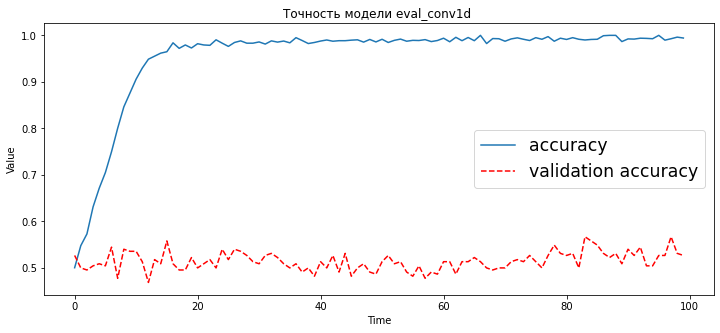

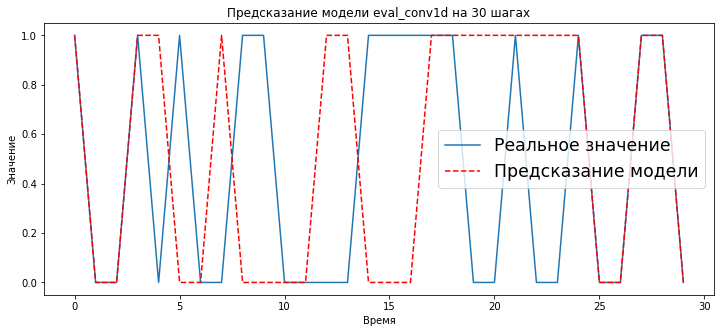

In [29]:
a = yVal
b = []
for i in model.predict(xVal):
    b.append(np.argmax(i))
show_accuracy(result, 'eval_conv1d')
show_result(a,b,30, 'eval_conv1d')

# Тестируем ещё одну простую полносвязную модель на генетике

In [37]:
def simple_dense():
    inp = Input((xVal.shape[1], xVal.shape[2]))
    flat = Flatten()(inp)
    bn = BatchNormalization()(flat)
    den = Dense(128, activation = 'relu')(bn)
    res = Dense(2, activation = 'sigmoid')(den)
    model = Model(inp,res)
    model.compile(loss = 'binary_crossentropy', optimizer = Adam(lr=0.0001), metrics = ['accuracy'])
    return model

In [38]:
model = simple_dense()

In [74]:
sval , popul = data_selection_dense(n_bot = 30, nsurv = 10, l_bot = 2, mut = 0.3, epochs = 50)

  0%|          | 0/30 [00:00<?, ?it/s]

Эпоха  0 4.19 мин  | [0.4419642984867096, 0.4464285671710968, 0.4508928656578064, 0.4508928656578064, 0.4508928656578064] [[11, 16], [15, 16], [4, 17], [6, 5], [15, 30]]


  0%|          | 0/30 [00:00<?, ?it/s]

Эпоха  1 4.18 мин  | [0.46875, 0.4732142984867096, 0.4732142984867096, 0.4821428656578064, 0.4821428656578064] [[15, 30], [6, 5], [19, 14], [19, 14], [19, 14]]


  0%|          | 0/30 [00:00<?, ?it/s]

Эпоха  2 4.15 мин  | [0.46875, 0.46875, 0.4732142984867096, 0.4776785671710968, 0.4776785671710968] [[15, 10], [19, 15], [19, 15], [6, 5], [6, 5]]


  0%|          | 0/30 [00:00<?, ?it/s]

Эпоха  3 4.17 мин  | [0.4732142984867096, 0.4732142984867096, 0.4732142984867096, 0.4776785671710968, 0.4821428656578064] [[15, 30], [15, 30], [15, 10], [15, 30], [15, 30]]


  0%|          | 0/30 [00:00<?, ?it/s]

Эпоха  4 4.13 мин  | [0.4732142984867096, 0.4776785671710968, 0.4776785671710968, 0.4776785671710968, 0.4776785671710968] [[6, 5], [6, 5], [6, 5], [6, 5], [15, 30]]


  0%|          | 0/30 [00:00<?, ?it/s]

Эпоха  5 4.1 мин  | [0.4776785671710968, 0.4776785671710968, 0.4776785671710968, 0.4776785671710968, 0.4776785671710968] [[6, 5], [6, 5], [6, 5], [6, 5], [6, 5]]


  0%|          | 0/30 [00:00<?, ?it/s]

Эпоха  6 4.14 мин  | [0.4776785671710968, 0.4776785671710968, 0.4776785671710968, 0.4776785671710968, 0.4776785671710968] [[6, 5], [6, 5], [6, 5], [6, 5], [6, 5]]


  0%|          | 0/30 [00:00<?, ?it/s]

Эпоха  7 4.14 мин  | [0.4776785671710968, 0.4776785671710968, 0.4776785671710968, 0.4776785671710968, 0.4776785671710968] [[6, 5], [6, 5], [6, 5], [6, 5], [6, 5]]


  0%|          | 0/30 [00:00<?, ?it/s]

Эпоха  8 4.16 мин  | [0.4776785671710968, 0.4776785671710968, 0.4776785671710968, 0.4776785671710968, 0.4776785671710968] [[6, 5], [6, 5], [6, 5], [6, 5], [6, 5]]


  0%|          | 0/30 [00:00<?, ?it/s]

Эпоха  9 4.1 мин  | [0.4732142984867096, 0.4776785671710968, 0.4776785671710968, 0.4776785671710968, 0.4776785671710968] [[6, 5], [6, 5], [6, 5], [6, 5], [6, 5]]


  0%|          | 0/30 [00:00<?, ?it/s]

Эпоха  10 4.19 мин  | [0.4776785671710968, 0.4776785671710968, 0.4776785671710968, 0.4776785671710968, 0.4776785671710968] [[6, 5], [6, 5], [6, 5], [6, 5], [6, 5]]


  0%|          | 0/30 [00:00<?, ?it/s]

Эпоха  11 4.14 мин  | [0.4776785671710968, 0.4776785671710968, 0.4776785671710968, 0.4776785671710968, 0.4776785671710968] [[6, 5], [6, 5], [6, 5], [6, 5], [6, 5]]


  0%|          | 0/30 [00:00<?, ?it/s]

Эпоха  12 4.22 мин  | [0.4776785671710968, 0.4776785671710968, 0.4776785671710968, 0.4776785671710968, 0.4776785671710968] [[6, 5], [6, 5], [6, 5], [6, 5], [6, 5]]


  0%|          | 0/30 [00:00<?, ?it/s]

Эпоха  13 4.16 мин  | [0.4821428656578064, 0.4821428656578064, 0.4821428656578064, 0.4821428656578064, 0.4821428656578064] [[6, 5], [6, 5], [6, 5], [6, 5], [6, 5]]


  0%|          | 0/30 [00:00<?, ?it/s]

Эпоха  14 4.2 мин  | [0.4776785671710968, 0.4821428656578064, 0.4821428656578064, 0.4821428656578064, 0.4821428656578064] [[6, 5], [6, 5], [6, 5], [6, 5], [6, 5]]


  0%|          | 0/30 [00:00<?, ?it/s]

Эпоха  15 4.19 мин  | [0.4821428656578064, 0.4821428656578064, 0.4821428656578064, 0.4821428656578064, 0.4821428656578064] [[6, 5], [6, 5], [6, 5], [6, 5], [6, 5]]


  0%|          | 0/30 [00:00<?, ?it/s]

Эпоха  16 4.25 мин  | [0.4821428656578064, 0.4821428656578064, 0.4821428656578064, 0.4821428656578064, 0.4821428656578064] [[6, 5], [6, 5], [6, 5], [6, 5], [6, 5]]


  0%|          | 0/30 [00:00<?, ?it/s]

Эпоха  17 4.22 мин  | [0.4821428656578064, 0.4821428656578064, 0.4821428656578064, 0.4821428656578064, 0.4821428656578064] [[6, 5], [6, 5], [6, 5], [6, 5], [6, 5]]


  0%|          | 0/30 [00:00<?, ?it/s]

Эпоха  18 4.3 мин  | [0.4821428656578064, 0.4821428656578064, 0.4821428656578064, 0.4821428656578064, 0.4821428656578064] [[6, 5], [6, 5], [6, 5], [6, 5], [6, 5]]


  0%|          | 0/30 [00:00<?, ?it/s]

Эпоха  19 4.22 мин  | [0.4821428656578064, 0.4821428656578064, 0.4821428656578064, 0.4821428656578064, 0.4821428656578064] [[6, 5], [6, 5], [6, 5], [6, 5], [6, 5]]


  0%|          | 0/30 [00:00<?, ?it/s]

Эпоха  20 4.13 мин  | [0.4821428656578064, 0.4821428656578064, 0.4821428656578064, 0.4821428656578064, 0.4821428656578064] [[6, 5], [6, 5], [6, 5], [6, 5], [6, 5]]


  0%|          | 0/30 [00:00<?, ?it/s]

Эпоха  21 4.14 мин  | [0.4821428656578064, 0.4821428656578064, 0.4821428656578064, 0.4821428656578064, 0.4821428656578064] [[6, 5], [6, 5], [6, 5], [6, 5], [6, 5]]


  0%|          | 0/30 [00:00<?, ?it/s]

Эпоха  22 4.13 мин  | [0.4821428656578064, 0.4821428656578064, 0.4821428656578064, 0.4821428656578064, 0.4821428656578064] [[6, 5], [6, 5], [6, 5], [6, 5], [6, 5]]


  0%|          | 0/30 [00:00<?, ?it/s]

Эпоха  23 4.16 мин  | [0.4821428656578064, 0.4821428656578064, 0.4821428656578064, 0.4821428656578064, 0.4821428656578064] [[6, 5], [6, 5], [6, 5], [6, 5], [6, 5]]


  0%|          | 0/30 [00:00<?, ?it/s]

Эпоха  24 4.19 мин  | [0.4821428656578064, 0.4821428656578064, 0.4821428656578064, 0.4821428656578064, 0.4821428656578064] [[6, 5], [6, 5], [6, 5], [6, 5], [6, 5]]


  0%|          | 0/30 [00:00<?, ?it/s]

Эпоха  25 4.16 мин  | [0.4821428656578064, 0.4821428656578064, 0.4821428656578064, 0.4821428656578064, 0.4821428656578064] [[6, 5], [6, 5], [6, 5], [6, 5], [6, 5]]


  0%|          | 0/30 [00:00<?, ?it/s]

Эпоха  26 4.17 мин  | [0.4821428656578064, 0.4821428656578064, 0.4821428656578064, 0.4866071343421936, 0.4866071343421936] [[6, 5], [6, 5], [6, 5], [6, 5], [6, 5]]


  0%|          | 0/30 [00:00<?, ?it/s]

Эпоха  27 4.16 мин  | [0.4866071343421936, 0.4866071343421936, 0.4866071343421936, 0.4866071343421936, 0.4866071343421936] [[6, 5], [6, 5], [6, 5], [6, 5], [6, 5]]


  0%|          | 0/30 [00:00<?, ?it/s]

Эпоха  28 4.17 мин  | [0.4866071343421936, 0.4866071343421936, 0.4866071343421936, 0.4866071343421936, 0.4910714328289032] [[6, 5], [6, 5], [6, 5], [6, 5], [6, 5]]


  0%|          | 0/30 [00:00<?, ?it/s]

Эпоха  29 4.18 мин  | [0.4866071343421936, 0.4910714328289032, 0.4910714328289032, 0.4910714328289032, 0.4910714328289032] [[6, 5], [6, 5], [6, 5], [6, 5], [6, 5]]


  0%|          | 0/30 [00:00<?, ?it/s]

Эпоха  30 4.19 мин  | [0.4910714328289032, 0.4910714328289032, 0.4910714328289032, 0.4910714328289032, 0.4910714328289032] [[6, 5], [6, 5], [6, 5], [6, 5], [6, 5]]


  0%|          | 0/30 [00:00<?, ?it/s]

Эпоха  31 4.2 мин  | [0.4910714328289032, 0.4910714328289032, 0.4910714328289032, 0.4910714328289032, 0.4910714328289032] [[6, 5], [6, 5], [6, 5], [6, 5], [6, 5]]


  0%|          | 0/30 [00:00<?, ?it/s]

Эпоха  32 4.22 мин  | [0.4910714328289032, 0.4910714328289032, 0.4910714328289032, 0.4910714328289032, 0.4910714328289032] [[6, 5], [6, 5], [6, 5], [6, 5], [6, 5]]


  0%|          | 0/30 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [45]:
trainDatagen, testDatagen, xVal, yVal = prep_data01(6, 5)
xVal.shape, yVal.shape

((236, 6, 15), (236,))

In [41]:
path = r'C:\Users\takhi\Desktop\Diploma\Simple_dense\simple_dense.h5'
checkpoint = ModelCheckpoint(filepath=path, save_weights_only=True,\
                            monitor='val_accuracy', mode='max', save_best_only=True)

reduce = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience= 5, verbose=0, mode="auto",
    min_delta=0.0001, cooldown=0, min_lr=1e-07)

stop = EarlyStopping(monitor="val_loss", min_delta=0, patience=20,\
                     verbose=0, mode="auto", baseline=None, restore_best_weights=True)

In [39]:
model = simple_dense()

In [42]:
result = model.fit(trainDatagen, epochs = 100, validation_data = testDatagen, callbacks = [checkpoint, reduce,stop] )

Epoch 1/100
2620/2620 [==============================] - 3s 881us/step - loss: 0.6932 - accuracy: 0.4985 - val_loss: 9.6345 - val_accuracy: 0.5085
Epoch 2/100
2620/2620 [==============================] - 2s 826us/step - loss: 0.6931 - accuracy: 0.5111 - val_loss: 9.0040 - val_accuracy: 0.5127
Epoch 3/100
2620/2620 [==============================] - 2s 814us/step - loss: 0.6931 - accuracy: 0.5040 - val_loss: 9.2928 - val_accuracy: 0.5169
Epoch 4/100
2620/2620 [==============================] - 2s 818us/step - loss: 0.6928 - accuracy: 0.5271 - val_loss: 9.2109 - val_accuracy: 0.5169
Epoch 5/100
2620/2620 [==============================] - 2s 812us/step - loss: 0.6933 - accuracy: 0.4934 - val_loss: 9.3777 - val_accuracy: 0.5127
Epoch 6/100
2620/2620 [==============================] - 2s 812us/step - loss: 0.6932 - accuracy: 0.5022 - val_loss: 8.9131 - val_accuracy: 0.5127
Epoch 7/100
2620/2620 [==============================] - 2s 826us/step - loss: 0.6931 - accuracy: 0.5067 - val_loss: 9

In [54]:
df_2.iloc[:3,12]

0    0.0
1    1.0
2    1.0
Name: tr_1, dtype: float64

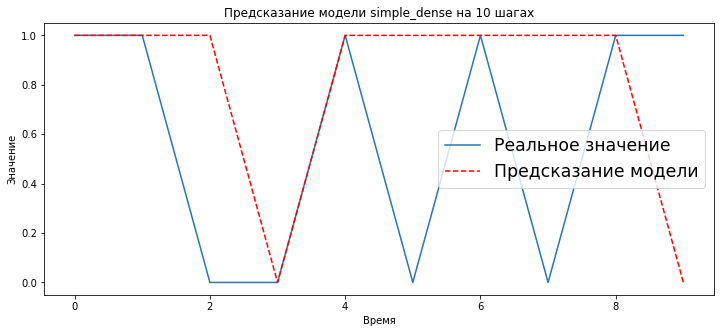

In [57]:
show_result(xVal, yVal, model, 10, 'simple_dense')

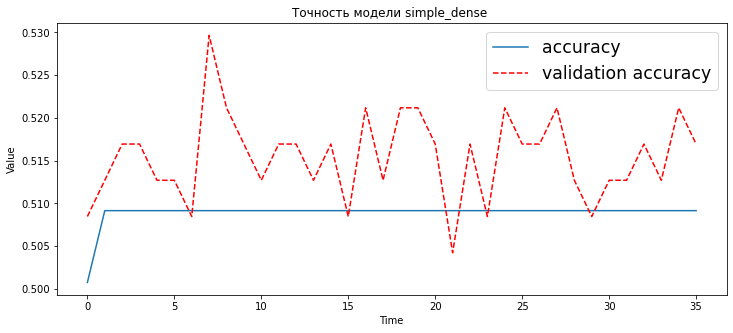

In [59]:
show_accuracy(result, 'simple_dense')

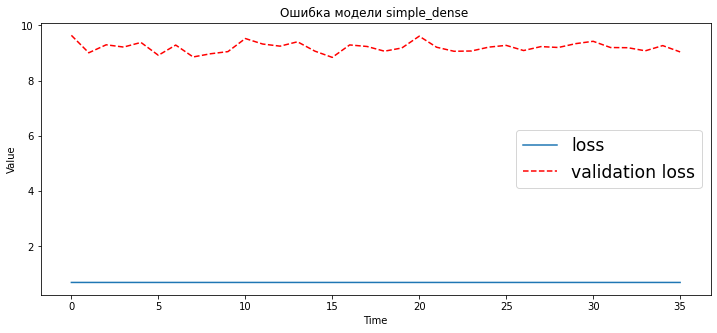

In [61]:
show_loss(result, 'simple_dense')